In [37]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [38]:
data, dataName = loadData.loadData("all_main.csv")


 Total trials before cleaning
: 29177
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 24471


In [39]:
intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"
#s
visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)
print("Visual test duration range:", data["recordedDurVisualTest"].min(), "to", data["recordedDurVisualTest"].max())
print("t_min, t_max:", mc_fitter.t_min, mc_fitter.t_max)

Visual test duration range: 0.0238 to 1.2582
t_min, t_max: 0.0249 0.99539


# Fit data

In [40]:
# fit parameters
mc_fitter.nSimul = 1000
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.modelName = "lognorm"  # Set measurement distribution to Gaussian
mc_fitter.sharedLambda = False  # Use separate lapse rates for each condition
mc_fitter.freeP_c = 0  # Allow different prior widths for conflict conditions

mc_fitter.dataName = dataName

# If not fitted load fitted parameters

In [41]:
# read back the saved file to verify

import os
import json
import loadResults
try:
    
    res=loadResults.loadFitResults(mc_fitter,dataName, modelName=mc_fitter.modelName)
    print(f"Loaded saved fit results: {res}")
    mc_fitter.modelFit= res['fittedParams']
    mc_fitter.logLikelihood= res['logLikelihood']
    mc_fitter.aic= res['AIC']
    mc_fitter.bic= res['BIC']
    mc_fitter.nDataPoints= res['n_conditions']
except:
    print("No saved fit results found, proceeding to fit the model.")
    timeStart = time.time()
    print(f"\nFitting Causal Inference Model for {dataName} with {len(mc_fitter.groupedData)} unique conditions")
    fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(mc_fitter.groupedData)
    print(f"\nFitted parameters for {dataName}: {fittedParams}")
    print(f"Time taken to fit: {time.time() - timeStart:.2f} seconds")
    mc_fitter.modelFit= fittedParams
    mc_fitter.logLikelihood= -mc_fitter.nLLMonteCarloCausal(fittedParams, mc_fitter.groupedData)    
    #save the fit results
    

Looking for saved fit: all_main with model lognorm_LapseFree_sharedPrior
Loaded saved fit results: {'participantID': 'all', 'modelType': 'lognorm_LapseFree_sharedPrior', 'fittedParams': [0.10387385, 0.26218953, 0.54385333, 0.98994297, 0.65054452, 0.0778586, 0.18420239], 'AIC': 27067.73294782409, 'BIC': 27114.298686780952, 'logLikelihood': -13526.866473912045, 'n_conditions': 5723}


In [42]:
import fitSaver
fitSaver.saveFitResultsSingle(mc_fitter, mc_fitter.modelFit, dataName)

✅ Saved fit for all (lognorm_LapseFree_sharedPrior) to: model_fits/all/all_lognorm_LapseFree_sharedPrior_fit.json


## Simulate data using fitted parameters

In [43]:
#proceed to simulate and save to {filename}
fitSaver

def loadSimulatedData(mc_fitter, dataName,participantID, modelType=mc_fitter.modelName):
    participantID = dataName.split(".csv")[0]
    #modelType = mc_fitter.modelName

    if mc_fitter.sharedLambda:
        modelType += "_LapseFix"
    else:
        modelType += "_LapseFree"

    if mc_fitter.freeP_c:
        modelType += "_contextualPrior"
    else:
        modelType += "_sharedPrior"

    filename = f"{participantID.split('_')[0]}_{modelType}_simulated.csv"
    filename = os.path.join("simulated_data",participantID.split('_')[0], filename)
    try:
        
        simulatedData= pd.read_csv(filename)
        print(f"Loaded saved simulated data from {filename}")
        return simulatedData
    except:
        print(f"No saved simulated data found at {filename}")
        fitSaver.saveSimulatedData(mc_fitter, mc_fitter.dataName)
        mc_fitter.simulatedData= pd.read_csv(filename)
        print(f"Simulated data saved to {filename}")
        return mc_fitter.simulatedData
#proceed to simulate and save to {filename}
mc_fitter.simulatedData=loadSimulatedData(mc_fitter, mc_fitter.dataName, participantID=dataName.split(".csv")[0], modelType=mc_fitter.modelName)


Loaded saved simulated data from simulated_data/all/all_lognorm_LapseFree_sharedPrior_simulated.csv


In [44]:
#mc_fitter.simulatedData = mc_fitter.simulateMonteCarloData(mc_fitter.modelFit, mc_fitter.data)
mc_fitter.simDataFit=mc_fitter.fitMultipleStartingPoints(mc_fitter.simulatedData,1)
"psychometric fit"
mc_fitter.dataFit= mc_fitter.fitMultipleStartingPoints(data,1)


# Plot the fits

Plotting psychometric curves for Monte Carlo model and data...
Noise: 1.2, Conflict: -0.25, Lambda: 0.184, Sigma_a: 0.651, Sigma_v: 0.544, p_c: 0.990
Noise: 1.2, Conflict: -0.17, Lambda: 0.104, Sigma_a: 0.651, Sigma_v: 0.544, p_c: 0.990
Noise: 1.2, Conflict: -0.08, Lambda: 0.078, Sigma_a: 0.651, Sigma_v: 0.544, p_c: 0.990
Noise: 1.2, Conflict: 0.0, Lambda: 0.104, Sigma_a: 0.651, Sigma_v: 0.544, p_c: 0.990
Noise: 1.2, Conflict: 0.08, Lambda: 0.184, Sigma_a: 0.651, Sigma_v: 0.544, p_c: 0.990
Noise: 1.2, Conflict: 0.17, Lambda: 0.078, Sigma_a: 0.651, Sigma_v: 0.544, p_c: 0.990
Noise: 1.2, Conflict: 0.25, Lambda: 0.104, Sigma_a: 0.651, Sigma_v: 0.544, p_c: 0.990


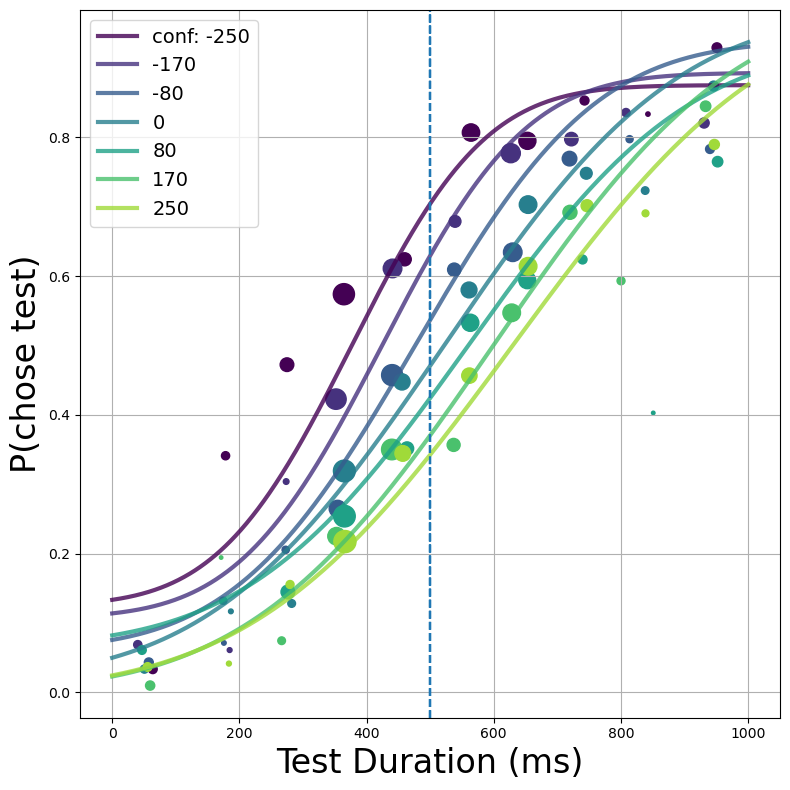

In [45]:
from matplotlib import pyplot as plt
import seaborn as sns
def bin_and_plot(data, bin_method='cut', bins=10, bin_range=None, plot=True,color="blue",binVar='delta_dur_percents'):
    if bin_method == 'cut':
        data['bin'] = pd.cut(data[binVar], bins=bins, labels=False, include_lowest=True, retbins=False)
    elif bin_method == 'manual':
        data['bin'] = np.digitize(data[binVar], bins=bin_range) - 1
    
    grouped = data.groupby('bin').agg(
        x_mean=(binVar, 'mean'),
        y_mean=('p_choose_test', 'mean'),
        total_resp=('total_responses', 'sum')
    )

    if plot:
        plt.scatter(grouped['x_mean'], grouped['y_mean'], s=grouped['total_resp']/data['total_responses'].sum()*900, color=color)

def plotPsychometrics_MC_Data(self):
    "use self to get the  required stuff"
    print("Plotting psychometric curves for Monte Carlo model and data...")
    pltTitle = self.dataName + " "+ self.modelName+" Model Fit"
    plt.figure(figsize=(8, 8))
    #plt.title(f"{pltTitle} AV,A duration comparison", fontsize=26)
    plt.xlabel("Test Duration (ms)", fontsize=24)
    plt.ylabel("P(chose test)",fontsize=24)

    for i, standardLevel in enumerate(self.uniqueStandard):
        for j, audioNoiseLevel in enumerate(sorted(self.uniqueSensory)[1:2]):
            for k, conflictLevel in enumerate(self.uniqueConflict):
                #plt.subplot(1, 2, j + 1)
                x = np.linspace(-0.6, 0.6, 1000)
                color = sns.color_palette("viridis", as_cmap=True)(k / len(self.uniqueConflict))
                
                paramsSimFit=self.getParams(self.simDataFit.x, conflictLevel,audioNoiseLevel)
                # Plot data fit: plot psychometric curve from fitted data
                ySimSigmoid=self.psychometric_function(x, paramsSimFit[0],paramsSimFit[1],paramsSimFit[2])

                
                xPlot=np.linspace(0,1000,1000)
                if k==0:
                    plt.plot(xPlot, ySimSigmoid, color=color, linestyle='-', label=f"conf: {int(conflictLevel*1000)}", linewidth=3, alpha=0.8)
                else:
                    plt.plot(xPlot, ySimSigmoid, color=color, linestyle='-', linewidth=3, alpha=0.8,label=f"{int(conflictLevel*1000)}")
                plt.axvline(500, linestyle='--')


                "plot the monte carlo"
                lambda_, sigma_av_a, sigma_av_v, p_c = self.getParamsCausal(self.modelFit, audioNoiseLevel, conflictLevel)

        
                #plt.axvline(x=0, color='gray', linestyle='--')
                #plt.axhline(y=0.5, color='gray', linestyle='--')
                #plt.xlabel(f"({self.intensityVar}) Test(stair-a)-Standard(a) Duration Difference Ratio(%)")
                #plt.xlabel("Test Duration (ms)", fontsize=24)
                #plt.title(f"{pltTitle} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=26)
                if j==0:
                    plt.legend(fontsize=14, title_fontsize=20)
                plt.grid()


                groupedDataSub = self.groupByChooseTest(
                    self.data[(self.data[self.standardVar] == standardLevel) & (self.data[self.sensoryVar] == audioNoiseLevel) & (self.data[self.conflictVar] == conflictLevel)],
                    [self.intensityVar, self.sensoryVar, self.standardVar, self.conflictVar, self.visualStandardVar, self.visualTestVar, self.audioTestVar, "testDurMs"]
                )
                bin_and_plot(groupedDataSub, bin_method='cut', bins=10, plot=True, color=color,binVar='testDurMs')
                #plt.text(0.05, 0.8, fr"$\sigma_a$: {sigma_av_a:.2f}, $\sigma_v$: {sigma_av_v:.2f},", fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
                plt.tight_layout()
                #plt.grid(True)
                print(f"Noise: {audioNoiseLevel}, Conflict: {conflictLevel}, Lambda: {lambda_:.3f}, Sigma_a: {sigma_av_a:.3f}, Sigma_v: {sigma_av_v:.3f}, p_c: {p_c:.3f}")
                #plt.text(0.15, 0.9, f"P(C=1): {p_c:.2f}", fontsize=12, ha='center', va='bottom', transform=plt.gca().transAxes)
                
    plt.show()

plotPsychometrics_MC_Data(mc_fitter)

Plotting psychometric curves for Monte Carlo model and data...
Noise: 0.1, Conflict: -0.25, Lambda: 0.184, Sigma_a: 0.262, Sigma_v: 0.544, p_c: 0.990
Noise: 0.1, Conflict: -0.17, Lambda: 0.104, Sigma_a: 0.262, Sigma_v: 0.544, p_c: 0.990
Noise: 0.1, Conflict: -0.08, Lambda: 0.078, Sigma_a: 0.262, Sigma_v: 0.544, p_c: 0.990
Noise: 0.1, Conflict: 0.0, Lambda: 0.104, Sigma_a: 0.262, Sigma_v: 0.544, p_c: 0.990
Noise: 0.1, Conflict: 0.08, Lambda: 0.184, Sigma_a: 0.262, Sigma_v: 0.544, p_c: 0.990
Noise: 0.1, Conflict: 0.17, Lambda: 0.078, Sigma_a: 0.262, Sigma_v: 0.544, p_c: 0.990
Noise: 0.1, Conflict: 0.25, Lambda: 0.104, Sigma_a: 0.262, Sigma_v: 0.544, p_c: 0.990
Noise: 1.2, Conflict: -0.25, Lambda: 0.184, Sigma_a: 0.651, Sigma_v: 0.544, p_c: 0.990
Noise: 1.2, Conflict: -0.17, Lambda: 0.104, Sigma_a: 0.651, Sigma_v: 0.544, p_c: 0.990
Noise: 1.2, Conflict: -0.08, Lambda: 0.078, Sigma_a: 0.651, Sigma_v: 0.544, p_c: 0.990
Noise: 1.2, Conflict: 0.0, Lambda: 0.104, Sigma_a: 0.651, Sigma_v: 0.544

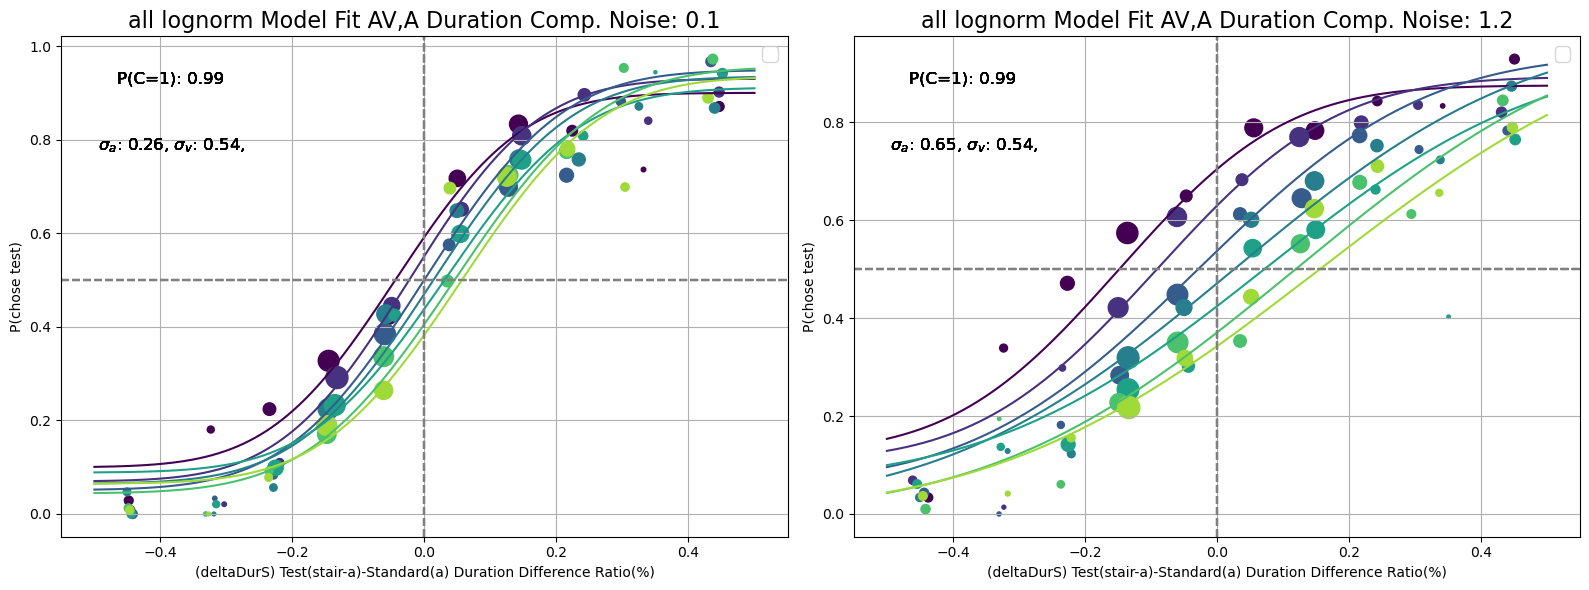

In [47]:
# from importlib import reload
# reload(monteCarloClass)
# import monteCarloClass
mc_fitter.dataName = dataName.split('_')[0]

mc_fitter.plotPsychometrics_MC_Data()

## If. not Bootstrapped boostrap the data data fits

In [52]:
## data bootstrap for mu vs conflict
dataBoots=mc_fitter.paramBootstrap( mc_fitter.dataFit.x, nBoots=1)



Bootstrapping: 100%|██████████| 1/1 [01:39<00:00, 99.85s/iteration]


In [57]:
import os
import json

def saveBootstrappedParams(mc_fitter, dataBoots, dataName):
    """
    Save bootstrapped parameters to JSON file, preserving array structure
    """
    participantID = dataName.split(".csv")[0]


    filename = f"{participantID.split('_')[0]}_data_bootstrapped_params.json"
    filename = os.path.join("bootstrapped_params", participantID.split('_')[0], filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # Convert numpy array to list while preserving structure
    if dataBoots is None:
        print("Warning: dataBoots is None, saving empty array")
        dataBoots_serializable = []
    elif isinstance(dataBoots, np.ndarray):
        # Convert the entire numpy array to a nested list, preserving all dimensions
        dataBoots_serializable = dataBoots.tolist()
    elif isinstance(dataBoots, (list, tuple)):
        # If it's already a list/tuple, convert any numpy arrays within it
        dataBoots_serializable = []
        for item in dataBoots:
            if isinstance(item, np.ndarray):
                dataBoots_serializable.append(item.tolist())
            else:
                dataBoots_serializable.append(item)
    else:
        # For other types, try to convert directly
        try:
            if hasattr(dataBoots, 'tolist'):
                dataBoots_serializable = dataBoots.tolist()
            else:
                dataBoots_serializable = [dataBoots]
        except Exception as e:
            print(f"Warning: Could not serialize dataBoots: {e}")
            dataBoots_serializable = []

    try:
        with open(filename, 'w') as f:
            json.dump(dataBoots_serializable, f, indent=2)
        print(f"Bootstrapped parameters saved to {filename}")
        print(f"Saved array shape: {np.array(dataBoots_serializable).shape if dataBoots_serializable else 'empty'}")
        return True
    except Exception as e:
        print(f"Error saving bootstrapped parameters: {e}")
        return False

def loadBootstrappedParams(mc_fitter, dataName):
    """
    Load bootstrapped parameters from JSON file, restoring original array structure
    """
    participantID = dataName.split(".csv")[0]


    filename = f"{participantID.split('_')[0]}_data_bootstrapped_params.json"
    filename = os.path.join("bootstrapped_params", participantID.split('_')[0], filename)
    
    if not os.path.exists(filename):
        print(f"Bootstrapped parameters file not found: {filename}")
        return None
    
    try:
        with open(filename, 'r') as f:
            content = f.read().strip()
            if not content:
                print(f"Warning: Empty file {filename}")
                return None
            
            dataBoots_list = json.loads(content)
        
        print(f"Loaded bootstrapped parameters from {filename}")
        
        # Convert the list back to numpy array, preserving the original structure
        if isinstance(dataBoots_list, list):
            if len(dataBoots_list) == 0:
                print("Warning: Loaded empty array")
                return np.array([])
            else:
                dataBoots_array = np.array(dataBoots_list)
                print(f"Loaded array shape: {dataBoots_array.shape}")
                return dataBoots_array
        else:
            # If for some reason it's not a list, try to convert anyway
            print("Warning: Loaded data is not a list, attempting conversion")
            return np.array(dataBoots_list)
            
    except json.JSONDecodeError as e:
        print(f"Error: Invalid JSON in {filename}: {e}")
        print("The file might be corrupted. Consider deleting it and regenerating the bootstrap data.")
        return None
    except Exception as e:
        print(f"Error loading bootstrapped parameters: {e}")
        return None


# If not bootstrapped DO IT!

In [21]:

# Save the current dataBoots array
saveBootstrappedParams(mc_fitter, dataBoots, dataName)


NameError: name 'dataBoots' is not defined

# If bootstrapped load fitted parameters

In [58]:

# Try to load existing bootstrapped parameters to test
dataBoots = loadBootstrappedParams(mc_fitter, dataName)
print(f"Original dataBoots shape: {dataBoots.shape}")

Loaded bootstrapped parameters from bootstrapped_params/all/all_data_bootstrapped_params.json
Loaded array shape: (100, 42)
Original dataBoots shape: (100, 42)


In [25]:
# other model fits
# load gaussian fit params from simulated data
mc_fitter.gaussianSim=loadSimulatedData(mc_fitter, mc_fitter.dataName, participantID=dataName.split(".csv")[0], modelType="gaussian")
mc_fitter.gaussianFit= mc_fitter.fitMultipleStartingPoints(mc_fitter.gaussianSim,1)

# load logLinearMismatch fit params from simulated data
mc_fitter.logLinearMismatchSim=loadSimulatedData(mc_fitter, mc_fitter.dataName, participantID=dataName.split(".csv")[0], modelType="logLinearMismatch")
mc_fitter.logLinearMismatchFit= mc_fitter.fitMultipleStartingPoints(mc_fitter.logLinearMismatchSim,1)



Loaded saved simulated data from simulated_data/all/all_gaussian_LapseFree_sharedPrior_simulated.csv
Loaded saved simulated data from simulated_data/all/all_logLinearMismatch_LapseFree_sharedPrior_simulated.csv


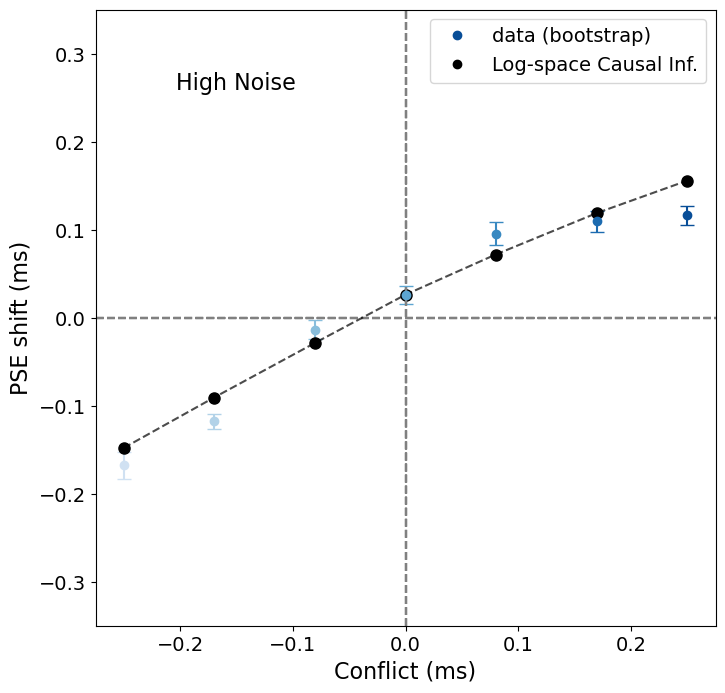

In [64]:

import matplotlib.pyplot as plt
import seaborn as sns  
def plot_mu_vs_conflict_MC_vs_Data(self):
    plt.figure(figsize=(8, 8))
    #plt.title(f"Mean Shift in PSE vs Conflict Level", fontsize=16)
    for i, standardLevel in enumerate(self.uniqueStandard):
        for j, audioNoiseLevel in enumerate(sorted(self.uniqueSensory)[1:2]):
            conflict_levels = []
            mu_models = []  
            for k, conflictLevel in enumerate(self.uniqueConflict):
                conflict_levels.append(conflictLevel)


                #plt.subplot(1, 2, j + 1)
                color = sns.color_palette("viridis", as_cmap=True)(k / len(self.uniqueConflict))
                
                # Plot bootstrap data fits
                for boot in dataBoots:
                    paramsBootDf = self.getParams(boot, conflictLevel, audioNoiseLevel)  # lambda mu sigma
                    muBoot = paramsBootDf[1]
                    #plt.scatter(conflictLevel, muBoot, color=color, s=10, alpha=0.1)
                # plot bootstrap mean
                bootMus = [self.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
                #plt.scatter(conflictLevel, np.mean(bootMus), color=color, s=20, alpha=0.7, label=f"Data Noise: {audioNoiseLevel}ms, Conflict: {conflictLevel}ms")
                #plot error bars

                if audioNoiseLevel == 0.1:
                    color = sns.color_palette("Reds", as_cmap=True)(0.2 + 0.8 * (k / len(self.uniqueConflict)))
                elif audioNoiseLevel == 1.2:
                    color = sns.color_palette("Blues", as_cmap=True)(0.2+ 0.8 * (k / len(self.uniqueConflict)))

                plt.errorbar(conflictLevel, np.mean(bootMus), yerr=np.std(bootMus), color=color, fmt='o', capsize=5, alpha=1)

                paramsSimDf = self.getParams(self.simDataFit.x, conflictLevel, audioNoiseLevel)  # lambda mu sigma
                muModel = paramsSimDf[1]
                #muData = self.getParams(self.dataFit.x, conflictLevel, audioNoiseLevel)[1]
                mu_models.append(muModel)

                #plt.scatter(conflictLevel, muData, color="red", s=40, alpha=0.7)
                #plt.scatter(conflictLevel, muModel, color="blue", s=40,  alpha=0.7)
                # or instead plot it as line plot
                #plt.plot(conflictLevel_sorted, muModel_sorted, color="blue", alpha=0.7, linestyle='--', marker='o', markersize=8)

                plt.plot(conflictLevel, muModel, color="black",  alpha=1,linestyle='--',marker='o',markersize=8)
                plt.xlabel(f"Conflict (ms)", fontsize=16)
                plt.ylabel("PSE shift (ms)", fontsize=16)
                plt.axhline(y=0, color='gray', linestyle='--')
                plt.axvline(x=0, color='gray', linestyle='--')
                plt.ylim(-0.35, 0.35)
                #plt.title(f"{self.dataName} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=16)

                plt.xticks(fontsize=14)
                plt.yticks(fontsize=14)

    
            # Convert lists to arrays and sort them for a proper line plot
            conflict_levels = np.array(conflict_levels)
            mu_models = np.array(mu_models)

            sorted_indices = np.argsort(conflict_levels)
            conflict_levels_sorted = conflict_levels[sorted_indices]
            mu_models_sorted = mu_models[sorted_indices]
            plt.plot(conflict_levels_sorted, mu_models_sorted, color="black", alpha=0.7, linestyle='--')


    plt.plot([], [], 'o', color=color, label='data (bootstrap)')
    plt.plot([], [], 'o', color='black', label='Log-space Causal Inf.')
    dictNoise = {0.1: 'Low Noise', 1.2: 'High Noise'}
    plt.text(0.13, 0.9, f"{dictNoise[audioNoiseLevel]}", fontsize=16, ha='left', va='top', transform=plt.gca().transAxes)
    plt.legend(fontsize=14, title_fontsize=14)
                                
    plt.show()


plot_mu_vs_conflict_MC_vs_Data(mc_fitter)

AttributeError: 'OmerMonteCarlo' object has no attribute 'lognormFreePcFit'

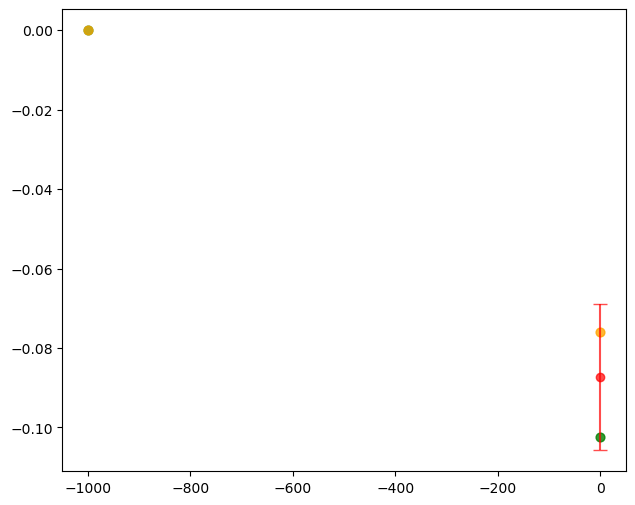

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  
def plot_mu_vs_conflict_MC_vs_Data(self):
    plt.figure(figsize=(16, 6))

    # Create empty lists to track what we've already labeled
    data_labeled = False
    model_labeled = False
    
    for i, standardLevel in enumerate(self.uniqueStandard):
        for j, audioNoiseLevel in enumerate(sorted(self.uniqueSensory)):
            plt.subplot(1, 2, j + 1)
            if j == 0:
                plt.scatter(-1000, 0, color="green", s=40, alpha=0.7, label="gaussian model")
                plt.scatter(-1000, 0, color="orange", s=40, alpha=0.7, label="loglinmismatch model")

            
            for k, conflictLevel in enumerate(self.uniqueConflict):
                color = sns.color_palette("viridis", as_cmap=True)(k / len(self.uniqueConflict))
                
                # Plot bootstrap data fits
                for boot in dataBoots:
                    paramsBootDf = self.getParams(boot, conflictLevel, audioNoiseLevel)  # lambda mu sigma
                    muBoot = paramsBootDf[1]
                    #plt.scatter(conflictLevel, muBoot, color=color, s=10, alpha=0.1)
                
                # plot bootstrap mean
                bootMus = [self.getParams(boot, conflictLevel, audioNoiseLevel)[1]*2 for boot in dataBoots]
                
                # Add label only once for data points
                label = "data (bootstrap)" if not data_labeled else None
                plt.errorbar(conflictLevel, np.mean(bootMus), yerr=np.std(bootMus), 
                            color="red", fmt='o', capsize=5, alpha=0.7, label=label)
                if not data_labeled:
                    data_labeled = True

                #gaussian model fit pse
                paramsGaussSimDf = mc_fitter.getParams(mc_fitter.gaussianFit.x, conflictLevel, audioNoiseLevel)  # lambda mu sigma
                muGaussModel = paramsGaussSimDf[1]*2
                plt.scatter(conflictLevel, muGaussModel, color="green", s=40, alpha=0.8)

                # loglinmismatch fit pse
                paramsLogLinMismatchSimDf = mc_fitter.getParams(mc_fitter.logLinearMismatchFit.x, conflictLevel, audioNoiseLevel)  # lambda mu sigma
                muLogLinMismatchModel = paramsLogLinMismatchSimDf[1]*2
                plt.scatter(conflictLevel, muLogLinMismatchModel, color="orange", s=40, alpha=0.8)

                # lognormFreePcSim fit pse
                
                paramsLogNormFreePcSimDf = mc_fitter.getParams(mc_fitter.lognormFreePcFit.x, conflictLevel, audioNoiseLevel)  # lambda mu sigma
                muLogNormFreePcModel = paramsLogNormFreePcSimDf[1]*2
                plt.scatter(conflictLevel, muLogNormFreePcModel, color="purple", s=40, alpha=0.8)

                paramsSimDf = self.getParams(self.simDataFit.x, conflictLevel, audioNoiseLevel)  # lambda mu sigma
                muModel = paramsSimDf[1]*2
                muData = self.getParams(self.dataFit.x, conflictLevel, audioNoiseLevel)[1]
                
                # Add label only once for model fits
                label = "model fits" if not model_labeled else None
                plt.scatter(conflictLevel, muModel, color="blue", s=40, alpha=0.8, label=label)
                if not model_labeled:
                    model_labeled = True
            
            # Set subplot properties after all points are plotted
            plt.xlim(-0.27, 0.27)
            plt.xlabel(f"Conflict (ms)")
            plt.ylabel("Mu (sigma_av_a)")
            plt.axhline(y=0, color='gray', linestyle='--')
            plt.axvline(x=0, color='gray', linestyle='--')
            plt.ylim(-0.6, 0.6)
            plt.title(f"{self.dataName} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=16)
            plt.grid()
            
            # Add legend once per subplot
            plt.legend()
                
    plt.show()
plot_mu_vs_conflict_MC_vs_Data(mc_fitter)

# Mu and conflict across participants

In [ ]:
# Main collector function
def collect_mus_across_participants(participant_ids, modelType="lognorm_LapseFree_sharedPrior"):
    results = []

    for pid in participant_ids:
        file_path = os.path.join("simulated_data", pid, f"{pid}_{modelType}_simulated.csv")
        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            continue
        
        df = pd.read_csv(file_path)
        newFitter= monteCarloClass.OmerMonteCarlo(df)
        simFit= newFitter.fitMultipleStartingPoints(df,1)
        for i, standardLevel in enumerate(newFitter.uniqueStandard):
            for j, audioNoiseLevel in enumerate(sorted(newFitter.uniqueSensory)):
                for k, conflictLevel in enumerate(newFitter.uniqueConflict):
                    paramsSimDf = newFitter.getParams(simFit.x, conflictLevel, audioNoiseLevel)  # lambda mu sigma
                    muModel = paramsSimDf[1]
                    results.append({
                        "participant_id": pid,
                        "standard_level": standardLevel,
                        "audio_noise_level": audioNoiseLevel,
                        "conflict_level": conflictLevel,
                        "mu_model": muModel
                    })
    return pd.DataFrame(results)

participant_ids = ["LN01", "as", "oy", "dt", "HH", "ip", "ln",  "mh", "ml", "mt", "qs", "sx"]
mus_df = collect_mus_across_participants(participant_ids)
mus_df



,participant_id,standard_level,audio_noise_level,conflict_level,mu_model
0,LN01,0.5,0.1,-0.25,-0.049481
1,LN01,0.5,0.1,-0.17,-0.005330
2,LN01,0.5,0.1,-0.08,0.005169
3,LN01,0.5,0.1,0.00,0.027550
4,LN01,0.5,0.1,0.08,0.030333
...,...,...,...,...,...
163,sx,0.5,1.2,-0.08,-0.050234
164,sx,0.5,1.2,0.00,0.019842
165,sx,0.5,1.2,0.08,0.087376
166,sx,0.5,1.2,0.17,0.165565


In [ ]:

def plot_mu_vs_conflict_MC_vs_Data_wErrorBars(mus_df):
    plt.figure(figsize=(16, 6))
    modelType="lognorm_LapseFree_sharedPrior"
    for j, audioNoiseLevel in enumerate(sorted(mus_df['audio_noise_level'].unique())):
        plt.subplot(1, 2, j + 1)
        for k, conflictLevel in enumerate(sorted(mus_df['conflict_level'].unique())):
            subset = mus_df[mus_df['audio_noise_level'] == audioNoiseLevel]
            subset = subset[subset['conflict_level'] == conflictLevel]
            if subset.empty:
                continue
            mu_mean = subset['mu_model'].mean()
            paramsSimDf = mc_fitter.getParams(mc_fitter.simDataFit.x, conflictLevel, audioNoiseLevel)  # lambda
            muModel= paramsSimDf[1]
            mu_sem = subset['mu_model'].sem()
            plt.errorbar(conflictLevel, muModel, yerr=mu_sem, fmt='o', color='blue', capsize=5, label="Model Fit" if k == 0 else "")

            muData=mc_fitter.getParams(mc_fitter.dataFit.x, conflictLevel, audioNoiseLevel)[1]
            plt.scatter(conflictLevel, muData, color="red", s=40, alpha=0.7, label="Data Fit" if k == 0 else "")

        # give error bars definition what they are
        if j == 0:
            plt.text(0.05, 0.95, 'Error bars: SEM across participants', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.xlabel(f"Conflict (ms)")
        plt.ylabel("Mu PSE")
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.axvline(x=0, color='gray', linestyle='--')
        plt.ylim(-0.25, 0.25)
        plt.title(f"All Participants AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=16)
        plt.legend(fontsize=14, title_fontsize=14)
        plt.grid()
    plt.show()




In [ ]:
plot_mu_vs_conflict_MC_vs_Data_wErrorBars(mus_df)

NameError: name 'mus_df' is not defined

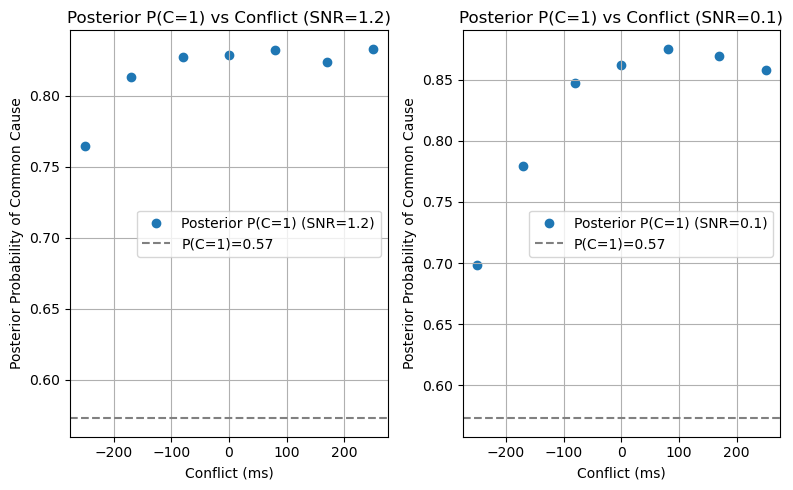

In [ ]:
fittedParams = mc_fitter.modelFit

mc_fitter.plot_posterior_vs_conflict(mc_fitter.data, mc_fitter.modelFit)

# Model Comparison Analysis

Now let's create comprehensive tables to compare all model fits across participants.

In [ ]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)
    
    for file_path in json_files:
        # if in filename "all_all", skip
        if "all" in os.path.basename(file_path):
            continue
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            
            if parts[2]!="LapseFree":
                #print("Lapse fixed model, skipping")
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}")

Error loading model_fits/sx/sx_lognorm_fit.json: list index out of range
Error loading model_fits/sx/sx_gaussian_fit.json: list index out of range
Error loading model_fits/sx/sx_logLinearMismatch_fit.json: list index out of range
Error loading model_fits/mt/mt_logLinearMismatch_fit.json: list index out of range
Error loading model_fits/mt/mt_lognorm_fit.json: list index out of range
Error loading model_fits/mt/mt_gaussian_fit.json: list index out of range
Error loading model_fits/mh/mh_logLinearMismatch_fit.json: list index out of range
Error loading model_fits/mh/mh_lognorm_fit.json: list index out of range
Error loading model_fits/mh/mh_gaussian_fit.json: list index out of range
Error loading model_fits/dt/dt_gaussian_fit.json: list index out of range
Error loading model_fits/dt/dt_lognorm_fit.json: list index out of range
Error loading model_fits/dt/dt_logLinearMismatch_fit.json: list index out of range
Error loading model_fits/oy/oy_lognorm_fit.json: list index out of range
Error l

In [ ]:
# Create comprehensive comparison table
def create_model_comparison_table(df_results):
    """Create a detailed comparison table of all model fits"""
    
    # Pivot table to compare models side by side
    comparison_cols = ['AIC', 'BIC', 'logLikelihood', 'n_conditions']
    
    summary_table = df_results.pivot_table(
        index='participantID', 
        columns='modelType', 
        values=comparison_cols,
        aggfunc='first'
    )
    
    return summary_table

# Create the comparison table
comparison_table = create_model_comparison_table(df_results)
print("Model Comparison Table:")
print("=" * 80)
print(comparison_table.round(3))

Model Comparison Table:
                                   AIC                       \
modelType     gaussian_contextualPrior gaussian_sharedPrior   
participantID                                                 
HH                            1814.014             1832.361   
LN01                          1148.697             1147.735   
as                            2255.965             2255.098   
dt                            2550.685             2549.487   
ip                            2448.484             2447.365   
ln                            2184.329             2180.880   
mh                            2478.590             2478.882   
ml                            2490.202             2503.121   
mt                            2216.531             2215.396   
oy                            2341.405             2337.978   
qs                            2525.620             2526.077   
sx                            2142.617             2144.689   

                              

In [ ]:
# Find best model for each participant (lowest AIC)
def find_best_models(df_results):
    """Find the best fitting model for each participant based on AIC"""
    best_models = []
    
    for participant in df_results['participantID'].unique():
        participant_data = df_results[df_results['participantID'] == participant]
        
        if len(participant_data) > 0:
            # Find model with lowest AIC
            best_idx = participant_data['AIC'].idxmin()
            best_model = participant_data.loc[best_idx]

            # delta AIC and BIC compared to the best model
            for _, row in participant_data.iterrows():
                if row['modelType'] != best_model['modelType']:
                    delta_AIC = row['AIC'] - best_model['AIC']
                    delta_BIC = row['BIC'] - best_model['BIC']
                    print(f"Participant {participant}, Model {row['modelType']} vs Best Model {best_model['modelType']}: ΔAIC={delta_AIC:.2f}, ΔBIC={delta_BIC:.2f}")
            
            best_models.append({
                'participantID': participant,
                'best_model': best_model['modelType'],
                'AIC': best_model['AIC'],
                'BIC': best_model['BIC'],
                'logLikelihood': best_model['logLikelihood'],
                'delta_AIC': delta_AIC,
                'delta_BIC': delta_BIC
            })
    
    return pd.DataFrame(best_models)

# Find best models
best_models_df = find_best_models(df_results)
print("\nBest Model for Each Participant (based on AIC):")
print("=" * 60)
print(best_models_df.round(3))

# Model performance summary
print(f"\nModel Performance Summary:")
print("=" * 40)
model_counts = best_models_df['best_model'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(best_models_df)) * 100
    print(f"{model}: {count} participants ({percentage:.1f}%)")

Participant sx, Model logLinearMismatch_contextualPrior vs Best Model gaussian_contextualPrior: ΔAIC=21.59, ΔBIC=21.59
Participant sx, Model lognorm_sharedPrior vs Best Model gaussian_contextualPrior: ΔAIC=7.04, ΔBIC=2.78
Participant sx, Model logLinearMismatch_sharedPrior vs Best Model gaussian_contextualPrior: ΔAIC=20.04, ΔBIC=15.78
Participant sx, Model lognorm_contextualPrior vs Best Model gaussian_contextualPrior: ΔAIC=6.64, ΔBIC=6.64
Participant sx, Model gaussian_sharedPrior vs Best Model gaussian_contextualPrior: ΔAIC=2.07, ΔBIC=-2.19
Participant mt, Model lognorm_sharedPrior vs Best Model logLinearMismatch_sharedPrior: ΔAIC=0.29, ΔBIC=0.29
Participant mt, Model lognorm_contextualPrior vs Best Model logLinearMismatch_sharedPrior: ΔAIC=2.46, ΔBIC=6.34
Participant mt, Model gaussian_contextualPrior vs Best Model logLinearMismatch_sharedPrior: ΔAIC=18.60, ΔBIC=22.48
Participant mt, Model logLinearMismatch_contextualPrior vs Best Model logLinearMismatch_sharedPrior: ΔAIC=5.47, ΔBIC

In [ ]:
# Create parameter comparison table
def create_parameter_table(df_results):
    """Create a table showing fitted parameters for each model and participant"""
    param_data = []
    
    for _, row in df_results.iterrows():
        params = row['fittedParams']
        if isinstance(params, list) and len(params) >= 4:
            param_data.append({
                'participantID': row['participantID'],
                'modelType': row['modelType'],
                'lambda': params[0] if len(params) > 0 else None,
                'sigma_av_a_low': params[1] if len(params) > 1 else None,
                'sigma_av_v_low': params[2] if len(params) > 2 else None,
                'p_c': params[3] if len(params) > 3 else None,
                'sigma_av_a_high': params[4] if len(params) > 4 else None,
                'sigma_av_v_high': params[5] if len(params) > 5 else None,
                'AIC': row['AIC'],
                'BIC': row['BIC']
            })
    
    return pd.DataFrame(param_data)

# Create parameter table
param_table = create_parameter_table(df_results)
print("\nFitted Parameters Summary:")
print("=" * 80)
print(param_table.round(4))


Fitted Parameters Summary:
   participantID                          modelType  lambda  sigma_av_a_low  \
0             sx  logLinearMismatch_contextualPrior  0.0000          0.3051   
1             sx                lognorm_sharedPrior  0.0001          0.3212   
2             sx      logLinearMismatch_sharedPrior  0.0000          0.3061   
3             sx            lognorm_contextualPrior  0.0009          0.3050   
4             sx           gaussian_contextualPrior  0.0240          0.1804   
..           ...                                ...     ...             ...   
67          LN01  logLinearMismatch_contextualPrior  0.0405          0.4027   
68          LN01           gaussian_contextualPrior  0.0001          0.1948   
69          LN01      logLinearMismatch_sharedPrior  0.1135          0.3699   
70          LN01                lognorm_sharedPrior  0.0463          0.4359   
71          LN01               gaussian_sharedPrior  0.0682          0.1721   

    sigma_av_v_low     

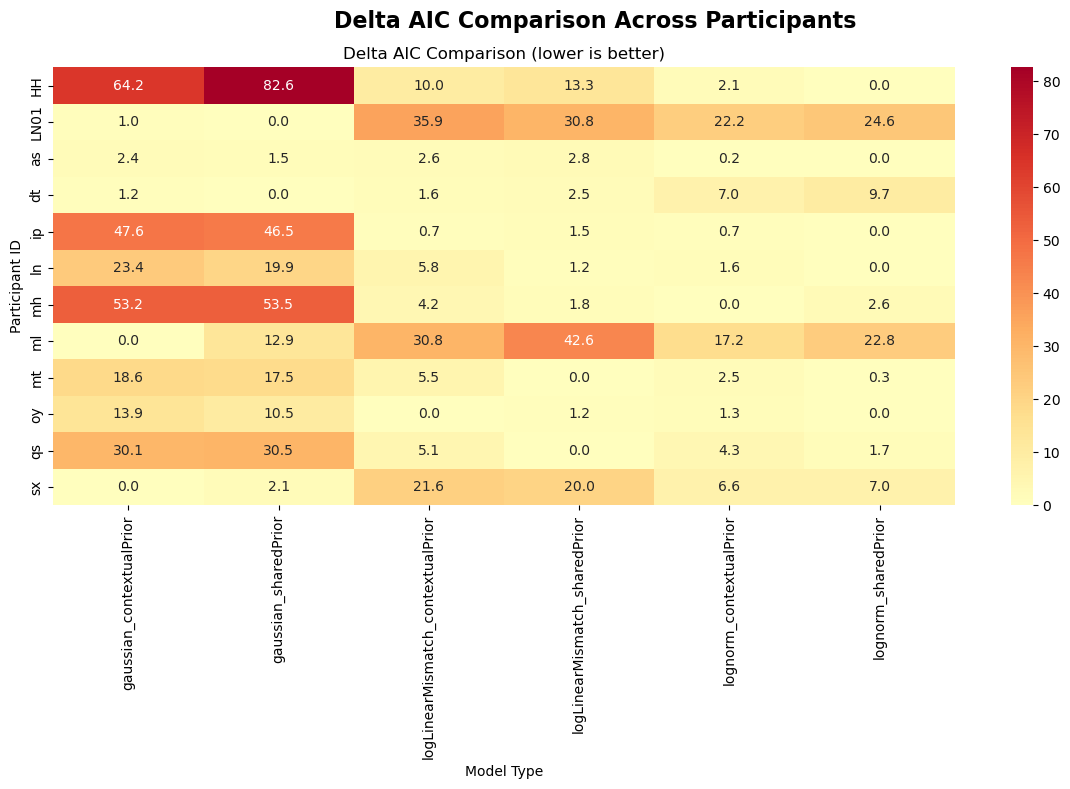

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create visualizations for model comparison based on delta_AIC
def plot_model_comparison_delta_aic(df_results):
    """Create plots comparing model performance based on delta_AIC"""
    
    # Calculate delta_AIC for each model relative to the best model
    df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())
    
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle('Delta AIC Comparison Across Participants', fontsize=16, fontweight='bold')
    
    # Heatmap for delta_AIC
    df_delta_aic = df_results.pivot(index='participantID', columns='modelType', values='delta_AIC')
    sns.heatmap(df_delta_aic, annot=True, fmt='.1f', cmap='RdYlBu_r', center=0, ax=axes)
    axes.set_title('Delta AIC Comparison (lower is better)')
    axes.set_ylabel('Participant ID')
    axes.set_xlabel('Model Type')
    
    plt.tight_layout()
    plt.show()

# Call the updated function
plot_model_comparison_delta_aic(df_results)

Participants sorted by sum of delta_AIC across all models (lowest to highest):
Delta_AIC sums: {'as': 9.436706531735581, 'dt': 21.96488708287643, 'oy': 26.933161997415937, 'mt': 44.28950099105168, 'ln': 51.893042566579425, 'sx': 57.36771624367475, 'qs': 71.57588044981685, 'ip': 96.93431748306557, 'LN01': 114.49269290333837, 'mh': 115.33839822809477, 'ml': 126.32877703046051, 'HH': 172.2573991155009}


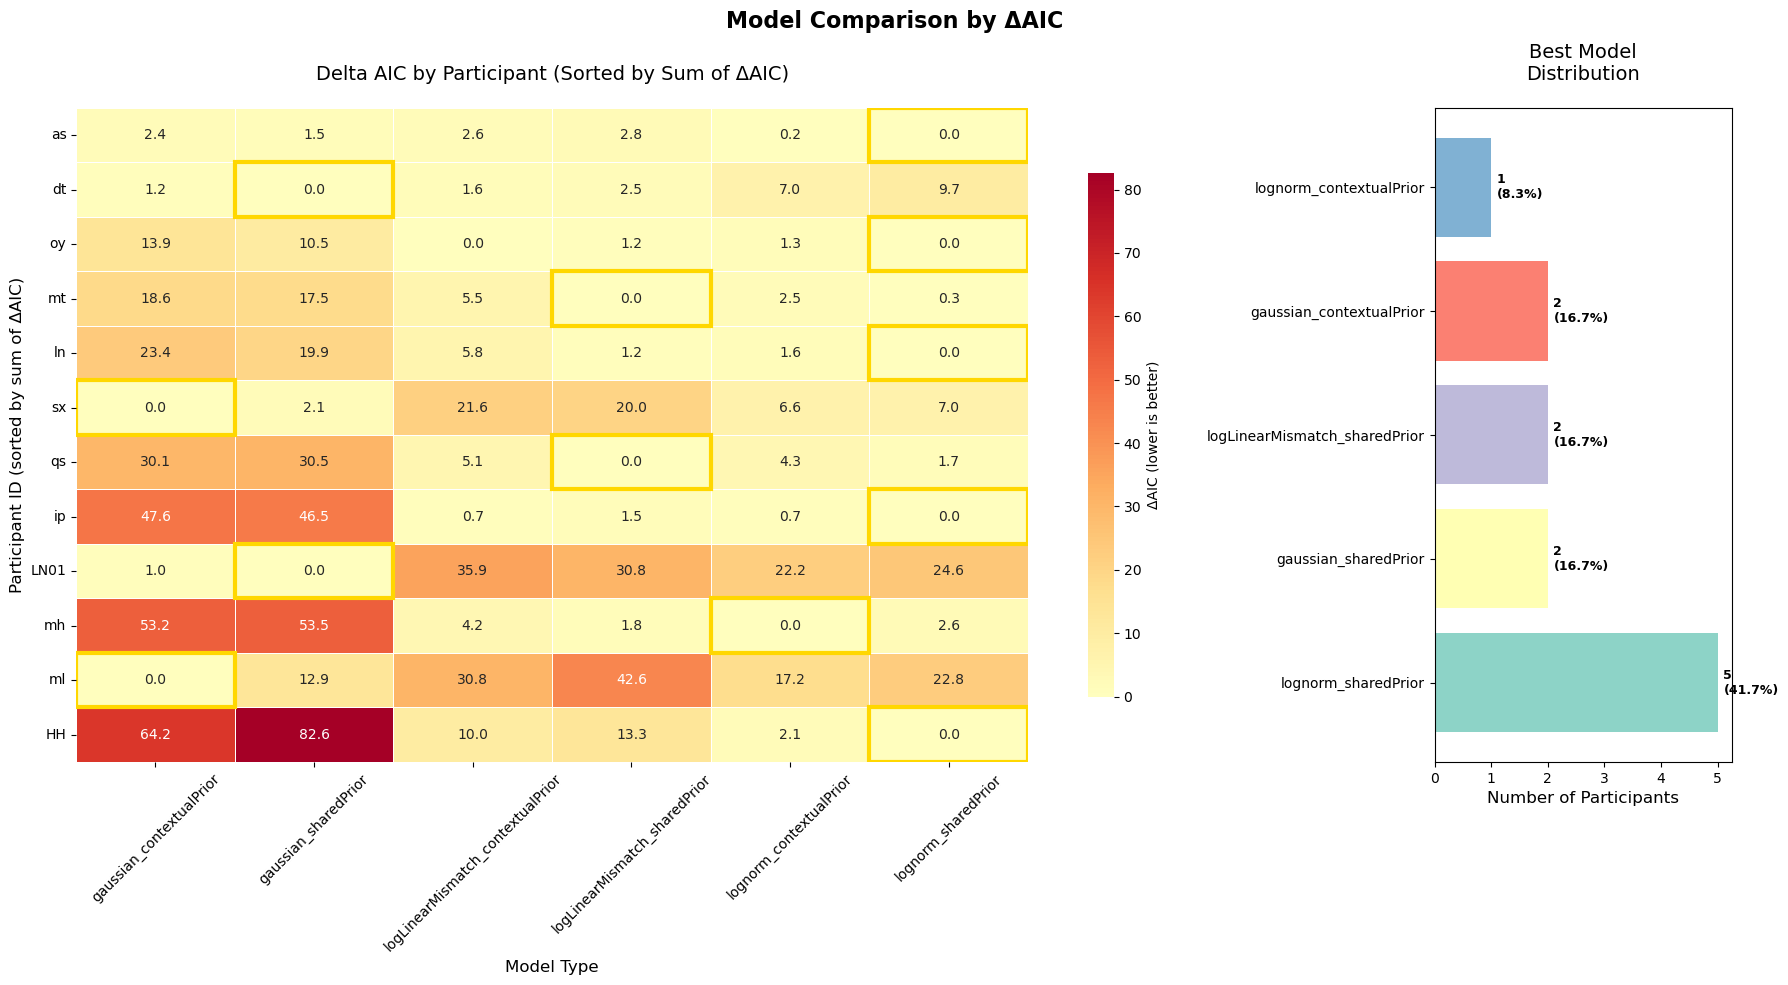


PARTICIPANT RANKING TABLE (sorted by sum of ΔAIC across all models)
Rank Participant  Sum ΔAIC   Best Model         Min ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    as           9.4        lognorm_sharedPrior 0.0        Good fit       
2    dt           22.0       gaussian_sharedPrior 0.0        Moderate fit   
3    oy           26.9       lognorm_sharedPrior 0.0        Moderate fit   
4    mt           44.3       logLinearMismatch_sharedPrior 0.0        Poor fit       
5    ln           51.9       lognorm_sharedPrior 0.0        Poor fit       
6    sx           57.4       gaussian_contextualPrior 0.0        Poor fit       
7    qs           71.6       logLinearMismatch_sharedPrior 0.0        Poor fit       
8    ip           96.9       lognorm_sharedPrior 0.0        Poor fit       
9    LN01         114.5      gaussian_sharedPrior 0.0        Poor fit       
10   mh           115.3      lognorm_contextualPrior 0

In [ ]:
# Calculate delta_AIC for each model relative to the best model per participant
df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())

# Sort participants by sum of delta_AIC across all models (lower sum = better overall performance)
participant_delta_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
sorted_participants = participant_delta_sums.index.tolist()
print("Participants sorted by sum of delta_AIC across all models (lowest to highest):")
print(f"Delta_AIC sums: {participant_delta_sums.to_dict()}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create enhanced table-style visualization
def plot_sorted_model_comparison_table(df_results):
    """Create a comprehensive table plot with participants sorted by sum of delta_AIC"""
    
    # Calculate delta_AIC for each model relative to the best model
    df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())
    
    # Sort participants by sum of delta_AIC across all models
    participant_delta_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
    sorted_participants = participant_delta_sums.index.tolist()
    
    # Create the pivot table with sorted participants
    df_delta_aic = df_results.pivot(index='participantID', columns='modelType', values='delta_AIC')
    df_delta_aic = df_delta_aic.reindex(sorted_participants)
    
    # Find best model for each participant
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['AIC'].idxmin(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by ΔAIC', fontsize=16, fontweight='bold')
    
    # Main heatmap with delta_AIC values
    sns.heatmap(df_delta_aic, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0,
                ax=ax1,
                cbar_kws={'label': 'ΔAIC (lower is better)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Delta AIC by Participant (Sorted by Sum of ΔAIC)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by sum of ΔAIC)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_delta_aic.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a star or border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='gold', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Model\nDistribution', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    # # Add legend explaining the gold borders
    # ax1.text(0.02, 0.98, '★ Gold border = Best model for participant', 
    #          transform=ax1.transAxes, fontsize=10, 
    #          bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.7),
    #          verticalalignment='top')
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by sum of ΔAIC across all models)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Sum ΔAIC':<10} {'Best Model':<18} {'Min ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        min_delta_aic = participant_data['delta_AIC'].min()
        best_model = participant_data.loc[participant_data['AIC'].idxmin(), 'modelType']
        
        if sum_delta_aic <= 5:
            performance = "Excellent fit"
        elif sum_delta_aic <= 15:
            performance = "Good fit"
        elif sum_delta_aic <= 30:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {sum_delta_aic:<10.1f} {best_model:<18} {min_delta_aic:<10.1f} {performance:<15}")
    
    return df_delta_aic, best_models, participant_delta_sums

# Create the enhanced visualization
delta_aic_table, participant_best_models, delta_sums = plot_sorted_model_comparison_table(df_results)

In [ ]:
# Save comprehensive results to CSV files
def save_comparison_results(df_results, best_models_df, param_table):
    """Save all comparison results to CSV files"""
    
    # Save main results
    df_results.to_csv('model_comparison_all_results.csv', index=False)
    print("✅ Saved complete results to: model_comparison_all_results.csv")
    
    # Save best models
    best_models_df.to_csv('best_models_by_participant.csv', index=False)
    print("✅ Saved best models to: best_models_by_participant.csv")
    
    # Save parameter table
    param_table.to_csv('fitted_parameters_all_models.csv', index=False)
    print("✅ Saved parameters to: fitted_parameters_all_models.csv")
    
    # Create summary statistics
    summary_stats = {
        'total_participants': len(df_results['participantID'].unique()),
        'total_model_fits': len(df_results),
        'models_tested': list(df_results['modelType'].unique()),
        'best_model_distribution': best_models_df['best_model'].value_counts().to_dict()
    }
    
    # Save summary
    with open('model_comparison_summary.json', 'w') as f:
        json.dump(summary_stats, f, indent=4)
    print("✅ Saved summary statistics to: model_comparison_summary.json")
    
    return summary_stats

# Save all results
summary_stats = save_comparison_results(df_results, best_models_df, param_table)

print(f"\n🎯 SUMMARY STATISTICS:")
print("=" * 50)
print(f"Total participants analyzed: {summary_stats['total_participants']}")
print(f"Total model fits: {summary_stats['total_model_fits']}")
print(f"Models tested: {', '.join(summary_stats['models_tested'])}")
print(f"\nBest model distribution:")
for model, count in summary_stats['best_model_distribution'].items():
    percentage = (count / summary_stats['total_participants']) * 100
    print(f"  {model}: {count} participants ({percentage:.1f}%)")

✅ Saved complete results to: model_comparison_all_results.csv
✅ Saved best models to: best_models_by_participant.csv
✅ Saved parameters to: fitted_parameters_all_models.csv
✅ Saved summary statistics to: model_comparison_summary.json

🎯 SUMMARY STATISTICS:
Total participants analyzed: 12
Total model fits: 72
Models tested: logLinearMismatch_contextualPrior, lognorm_sharedPrior, logLinearMismatch_sharedPrior, lognorm_contextualPrior, gaussian_contextualPrior, gaussian_sharedPrior

Best model distribution:
  lognorm_sharedPrior: 5 participants (41.7%)
  gaussian_contextualPrior: 2 participants (16.7%)
  logLinearMismatch_sharedPrior: 2 participants (16.7%)
  gaussian_sharedPrior: 2 participants (16.7%)
  lognorm_contextualPrior: 1 participants (8.3%)


# Statistical Analysis

Now let's perform comprehensive statistical tests to compare models.

In [ ]:
import scipy.stats as stats
from scipy.stats import chi2

# 1. Likelihood Ratio Tests for Model Comparison
def likelihood_ratio_test(ll_full, ll_reduced, df_diff):
    """
    Perform likelihood ratio test between two nested models
    
    Parameters:
    ll_full: log-likelihood of the more complex model
    ll_reduced: log-likelihood of the simpler model  
    df_diff: difference in degrees of freedom (number of parameters)
    
    Returns:
    LR statistic, p-value, and interpretation
    """
    # Calculate LR statistic
    LR = 2 * (ll_full - ll_reduced)
    
    # Calculate p-value using chi-square distribution
    p_value = 1 - chi2.cdf(LR, df_diff)
    
    # Interpretation
    significant = p_value < 0.05
    
    return {
        'LR_statistic': LR,
        'p_value': p_value,
        'df': df_diff,
        'significant': significant,
        'interpretation': 'Complex model significantly better' if significant else 'Simple model preferred'
    }

# Perform pairwise likelihood ratio tests for each participant
def perform_lr_tests(df_results):
    """Perform all pairwise LR tests for each participant"""
    lr_results = []
    
    participants = df_results['participantID'].unique()
    
    # Updated model types based on current data
    models = ['gaussian_contextualPrior', 'gaussian_sharedPrior', 
              'logLinearMismatch_contextualPrior', 'logLinearMismatch_sharedPrior',
              'lognorm_contextualPrior', 'lognorm_sharedPrior']
    
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        
        # Get log-likelihoods for each model
        model_lls = {}
        for model in models:
            model_data = p_data[p_data['modelType'] == model]
            if len(model_data) > 0:
                model_lls[model] = model_data.iloc[0]['logLikelihood']
        
        # Perform tests between related models
        if len(model_lls) >= 2:
            # Compare within model families (contextual vs shared)
            model_pairs = [
                ('gaussian_contextualPrior', 'gaussian_sharedPrior', 0),  # Same base model
                ('logLinearMismatch_contextualPrior', 'logLinearMismatch_sharedPrior', 0),  # Same base model
                ('lognorm_contextualPrior', 'lognorm_sharedPrior', 0),  # Same base model
                # Compare across model families with same prior type
                ('gaussian_contextualPrior', 'lognorm_contextualPrior', 0),  # Same prior type
                ('gaussian_sharedPrior', 'lognorm_sharedPrior', 0),  # Same prior type
                ('gaussian_contextualPrior', 'logLinearMismatch_contextualPrior', 0),  # Same prior type
                ('gaussian_sharedPrior', 'logLinearMismatch_sharedPrior', 0),  # Same prior type
                ('lognorm_contextualPrior', 'logLinearMismatch_contextualPrior', 0),  # Same prior type
                ('lognorm_sharedPrior', 'logLinearMismatch_sharedPrior', 0),  # Same prior type
            ]
            
            for model1, model2, df_diff in model_pairs:
                if model1 in model_lls and model2 in model_lls:
                    # Compare models (higher LL is "full" model)
                    if model_lls[model1] >= model_lls[model2]:
                        result = likelihood_ratio_test(model_lls[model1], model_lls[model2], abs(df_diff))
                        better_model = model1
                        worse_model = model2
                    else:
                        result = likelihood_ratio_test(model_lls[model2], model_lls[model1], abs(df_diff))
                        better_model = model2
                        worse_model = model1
                    
                    lr_results.append({
                        'participantID': participant,
                        'model1': model1,
                        'model2': model2,
                        'better_model': better_model,
                        'LR_stat': result['LR_statistic'],
                        'p_value': result['p_value'],
                        'significant': result['significant']
                    })
    
    return pd.DataFrame(lr_results)

# Run LR tests
print("Performing Likelihood Ratio Tests...")
lr_test_results = perform_lr_tests(df_results)
print("\nLikelihood Ratio Test Results:")
print("=" * 80)
print(lr_test_results.round(4))

Performing Likelihood Ratio Tests...

Likelihood Ratio Test Results:
    participantID                             model1  \
0              sx           gaussian_contextualPrior   
1              sx  logLinearMismatch_contextualPrior   
2              sx            lognorm_contextualPrior   
3              sx           gaussian_contextualPrior   
4              sx               gaussian_sharedPrior   
..            ...                                ...   
103          LN01               gaussian_sharedPrior   
104          LN01           gaussian_contextualPrior   
105          LN01               gaussian_sharedPrior   
106          LN01            lognorm_contextualPrior   
107          LN01                lognorm_sharedPrior   

                                model2                       better_model  \
0                 gaussian_sharedPrior           gaussian_contextualPrior   
1        logLinearMismatch_sharedPrior  logLinearMismatch_contextualPrior   
2                  lognorm_

In [ ]:
# 2. AIC/BIC Difference Analysis
def calculate_model_differences(df_results):
    """Calculate AIC and BIC differences between models"""
    diff_results = []
    
    participants = df_results['participantID'].unique()
    
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        
        # Get AIC and BIC for each model
        model_metrics = {}
        for _, row in p_data.iterrows():
            model = row['modelType']
            model_metrics[model] = {
                'AIC': row['AIC'],
                'BIC': row['BIC'],
                'logLikelihood': row['logLikelihood']
            }
        
        # Find best model (lowest AIC)
        if model_metrics:
            best_aic_model = min(model_metrics.keys(), key=lambda x: model_metrics[x]['AIC'])
            best_aic = model_metrics[best_aic_model]['AIC']
            
            best_bic_model = min(model_metrics.keys(), key=lambda x: model_metrics[x]['BIC'])
            best_bic = model_metrics[best_bic_model]['BIC']
            
            # Calculate differences from best model
            for model, metrics in model_metrics.items():
                aic_diff = metrics['AIC'] - best_aic
                bic_diff = metrics['BIC'] - best_bic
                
                # AIC interpretation (Burnham & Anderson, 2002)
                if aic_diff == 0:
                    aic_support = "Best model"
                elif aic_diff <= 2:
                    aic_support = "Substantial support"
                elif aic_diff <= 4:
                    aic_support = "Considerable support"  
                elif aic_diff <= 7:
                    aic_support = "Some support"
                else:
                    aic_support = "No support"
                
                # BIC interpretation (Kass & Raftery, 1995)
                if bic_diff == 0:
                    bic_support = "Best model"
                elif bic_diff <= 2:
                    bic_support = "Weak evidence against"
                elif bic_diff <= 6:
                    bic_support = "Positive evidence against"
                elif bic_diff <= 10:
                    bic_support = "Strong evidence against"
                else:
                    bic_support = "Very strong evidence against"
                
                diff_results.append({
                    'participantID': participant,
                    'modelType': model,
                    'AIC_diff': aic_diff,
                    'BIC_diff': bic_diff,
                    'AIC_support': aic_support,
                    'BIC_support': bic_support,
                    'is_best_AIC': model == best_aic_model,
                    'is_best_BIC': model == best_bic_model
                })
    
    return pd.DataFrame(diff_results)

# Calculate model differences
model_diffs = calculate_model_differences(df_results)
print("\nAIC/BIC Model Differences and Support:")
print("=" * 80)
model_diffs.round(3)


AIC/BIC Model Differences and Support:


,participantID,modelType,AIC_diff,BIC_diff,AIC_support,BIC_support,is_best_AIC,is_best_BIC
0,sx,logLinearMismatch_contextualPrior,21.585,23.771,No support,Very strong evidence against,False,False
1,sx,lognorm_sharedPrior,7.035,4.963,No support,Positive evidence against,False,False
2,sx,logLinearMismatch_sharedPrior,20.040,17.968,No support,Very strong evidence against,False,False
3,sx,lognorm_contextualPrior,6.636,8.822,Some support,Strong evidence against,False,False
4,sx,gaussian_contextualPrior,0.000,2.186,Best model,Positive evidence against,True,False
...,...,...,...,...,...,...,...,...
67,LN01,logLinearMismatch_contextualPrior,35.919,39.712,No support,Very strong evidence against,False,False
68,LN01,gaussian_contextualPrior,0.962,4.755,Substantial support,Positive evidence against,False,False
69,LN01,logLinearMismatch_sharedPrior,30.818,30.818,No support,Very strong evidence against,False,False
70,LN01,lognorm_sharedPrior,24.619,24.619,No support,Very strong evidence against,False,False


In [ ]:
# 3. Model Evidence and Bayes Factors
def calculate_bayes_factors(df_results):
    """Calculate Bayes factors using BIC approximation"""
    bf_results = []
    
    participants = df_results['participantID'].unique()
    
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        
        # Get BIC for each model
        model_bics = {}
        for _, row in p_data.iterrows():
            model_bics[row['modelType']] = row['BIC']
        
        if len(model_bics) >= 2:
            # Calculate Bayes factors relative to best model
            best_model = min(model_bics.keys(), key=lambda x: model_bics[x])
            best_bic = model_bics[best_model]
            
            for model, bic in model_bics.items():
                if model != best_model:
                    # BF approximation: BF = exp((BIC_worse - BIC_better)/2)
                    bf = np.exp((bic - best_bic) / 2)
                    
                    # Interpretation (Kass & Raftery, 1995)
                    if bf < 1:
                        evidence = "Model preferred"
                    elif bf < 3:
                        evidence = "Weak evidence against"
                    elif bf < 20:
                        evidence = "Positive evidence against"
                    elif bf < 150:
                        evidence = "Strong evidence against"
                    else:
                        evidence = "Very strong evidence against"
                    
                    bf_results.append({
                        'participantID': participant,
                        'model': model,
                        'reference_model': best_model,
                        'bayes_factor': bf,
                        'log_BF': np.log(bf),
                        'evidence_strength': evidence,
                        'BIC_diff': bic - best_bic
                    })
    
    return pd.DataFrame(bf_results)

# Calculate Bayes factors
bayes_factors = calculate_bayes_factors(df_results)
print("\nBayes Factors (relative to best model per participant):")
print("=" * 80)
print(bayes_factors.round(3))


Bayes Factors (relative to best model per participant):
   participantID                              model  \
0             sx  logLinearMismatch_contextualPrior   
1             sx                lognorm_sharedPrior   
2             sx      logLinearMismatch_sharedPrior   
3             sx            lognorm_contextualPrior   
4             sx           gaussian_contextualPrior   
5             mt                lognorm_sharedPrior   
6             mt            lognorm_contextualPrior   
7             mt           gaussian_contextualPrior   
8             mt  logLinearMismatch_contextualPrior   
9             mt               gaussian_sharedPrior   
10            mh            lognorm_contextualPrior   
11            mh  logLinearMismatch_contextualPrior   
12            mh                lognorm_sharedPrior   
13            mh           gaussian_contextualPrior   
14            mh               gaussian_sharedPrior   
15            dt                lognorm_sharedPrior   
16      

In [ ]:
# 4. Group-Level Statistical Tests
def group_level_analysis(df_results):
    """Perform group-level statistical tests across participants"""
    
    # Updated model types based on current data
    models = ['gaussian_contextualPrior', 'gaussian_sharedPrior', 
              'logLinearMismatch_contextualPrior', 'logLinearMismatch_sharedPrior',
              'lognorm_contextualPrior', 'lognorm_sharedPrior']
    
    # Create matrices for each metric
    participants = sorted(df_results['participantID'].unique())
    
    aic_matrix = np.full((len(participants), len(models)), np.nan)
    bic_matrix = np.full((len(participants), len(models)), np.nan)
    ll_matrix = np.full((len(participants), len(models)), np.nan)
    
    for i, participant in enumerate(participants):
        p_data = df_results[df_results['participantID'] == participant]
        for j, model in enumerate(models):
            model_data = p_data[p_data['modelType'] == model]
            if len(model_data) > 0:
                aic_matrix[i, j] = model_data.iloc[0]['AIC']
                bic_matrix[i, j] = model_data.iloc[0]['BIC'] 
                ll_matrix[i, j] = model_data.iloc[0]['logLikelihood']
    
    # Repeated measures ANOVA on AIC values
    print("Group-Level Analysis Results:")
    print("=" * 50)
    
    # Convert to long format for ANOVA
    aic_long = []
    for i, participant in enumerate(participants):
        for j, model in enumerate(models):
            if not np.isnan(aic_matrix[i, j]):
                aic_long.append({
                    'participant': participant,
                    'model': model,
                    'AIC': aic_matrix[i, j],
                    'BIC': bic_matrix[i, j],
                    'logLikelihood': ll_matrix[i, j]
                })
    
    aic_df = pd.DataFrame(aic_long)
    
    # Friedman test (non-parametric repeated measures)
    if len(aic_df) > 0:
        # Prepare data for Friedman test - only include models that all participants have
        complete_participants = []
        for participant in participants:
            participant_models = aic_df[aic_df['participant'] == participant]['model'].unique()
            if len(participant_models) == len(models):  # Participant has all models
                complete_participants.append(participant)
        
        if len(complete_participants) >= 3:  # Need at least 3 participants for meaningful test
            print(f"Running Friedman test on {len(complete_participants)} participants with complete data")
            
            # Prepare data for Friedman test
            friedman_data = []
            for model in models:
                model_aics = []
                for participant in complete_participants:
                    participant_model_data = aic_df[(aic_df['participant'] == participant) & 
                                                   (aic_df['model'] == model)]
                    if len(participant_model_data) > 0:
                        model_aics.append(participant_model_data.iloc[0]['AIC'])
                
                if len(model_aics) == len(complete_participants):
                    friedman_data.append(model_aics)
            
            if len(friedman_data) == len(models) and all(len(x) == len(friedman_data[0]) for x in friedman_data):
                # Friedman test for AIC
                friedman_stat, friedman_p = stats.friedmanchisquare(*friedman_data)
                print(f"Friedman Test (AIC): χ² = {friedman_stat:.3f}, p = {friedman_p:.4f}")
                
                if friedman_p < 0.05:
                    print("→ Significant differences between models detected!")
                    
                    # Post-hoc pairwise comparisons using Wilcoxon signed-rank test
                    print("\nPost-hoc pairwise comparisons (Wilcoxon signed-rank):")
                    print("Note: Only showing comparisons between key model pairs due to large number of models")
                    
                    # Key comparisons: within model families and between major types
                    key_comparisons = [
                        (0, 1, 'gaussian_contextual vs gaussian_shared'),
                        (2, 3, 'logLinearMismatch_contextual vs logLinearMismatch_shared'),
                        (4, 5, 'lognorm_contextual vs lognorm_shared'),
                        (0, 4, 'gaussian_contextual vs lognorm_contextual'),
                        (1, 5, 'gaussian_shared vs lognorm_shared'),
                        (0, 2, 'gaussian_contextual vs logLinearMismatch_contextual'),
                        (1, 3, 'gaussian_shared vs logLinearMismatch_shared')
                    ]
                    
                    n_comparisons = len(key_comparisons)
                    
                    for i, j, comparison in key_comparisons:
                        if i < len(friedman_data) and j < len(friedman_data):
                            if len(friedman_data[i]) == len(friedman_data[j]):
                                stat, p_val = stats.wilcoxon(friedman_data[i], friedman_data[j])
                                effect_size = np.abs(np.mean(friedman_data[i]) - np.mean(friedman_data[j])) / np.std(np.concatenate([friedman_data[i], friedman_data[j]]))
                                
                                # Bonferroni correction
                                p_corrected = p_val * n_comparisons
                                significance = "***" if p_corrected < 0.001 else "**" if p_corrected < 0.01 else "*" if p_corrected < 0.05 else "ns"
                                
                                print(f"  {comparison}: Z = {stat:.3f}, p = {p_val:.4f}, p_corr = {p_corrected:.4f} {significance}")
                                print(f"    Effect size (Cohen's d): {effect_size:.3f}")
                else:
                    print("→ No significant differences between models")
            else:
                print("→ Insufficient complete data for Friedman test")
        else:
            print(f"→ Only {len(complete_participants)} participants have complete data, need at least 3 for test")
    
    return aic_df

# Run group-level analysis
group_analysis_df = group_level_analysis(df_results)

Group-Level Analysis Results:
Running Friedman test on 12 participants with complete data
Friedman Test (AIC): χ² = 7.905, p = 0.1616
→ No significant differences between models


In [ ]:
# 5. Parameter Distribution Analysis
def analyze_parameter_distributions(param_table):
    """Analyze distributions of fitted parameters across models and participants"""
    
    print("\nParameter Distribution Analysis:")
    print("=" * 60)
    
    # Group by model type
    models = param_table['modelType'].unique()
    
    for model in models:
        model_data = param_table[param_table['modelType'] == model]
        
        print(f"\n{model.upper()} Model Parameters:")
        print("-" * 40)
        
        # Key parameters to analyze
        param_cols = ['lambda', 'sigma_av_a_low', 'sigma_av_v_low', 'p_c']
        
        for param in param_cols:
            if param in model_data.columns:
                values = model_data[param].dropna()
                if len(values) > 0:
                    print(f"{param}:")
                    print(f"  Mean ± SD: {values.mean():.3f} ± {values.std():.3f}")
                    print(f"  Range: [{values.min():.3f}, {values.max():.3f}]")
                    print(f"  Median (IQR): {values.median():.3f} ({values.quantile(0.25):.3f}-{values.quantile(0.75):.3f})")
    
    # Cross-model parameter comparisons
    print(f"\nCross-Model Parameter Comparisons:")
    print("-" * 50)
    
    param_cols = ['lambda', 'p_c']  # Parameters that should be comparable across models
    
    for param in param_cols:
        print(f"\n{param.upper()} parameter across models:")
        
        param_by_model = {}
        for model in models:
            model_data = param_table[param_table['modelType'] == model]
            if param in model_data.columns:
                values = model_data[param].dropna()
                if len(values) > 0:
                    param_by_model[model] = values.values
        
        if len(param_by_model) >= 2:
            # Kruskal-Wallis test for differences between models
            groups = list(param_by_model.values())
            if all(len(group) > 0 for group in groups):
                h_stat, kw_p = stats.kruskal(*groups)
                print(f"  Kruskal-Wallis H = {h_stat:.3f}, p = {kw_p:.4f}")
                
                if kw_p < 0.05:
                    print(f"  → Significant differences between models!")
                else:
                    print(f"  → No significant differences between models")
                
                # Effect size (eta-squared approximation)
                total_n = sum(len(group) for group in groups)
                eta_sq = (h_stat - len(groups) + 1) / (total_n - len(groups))
                print(f"  Effect size (η²): {eta_sq:.3f}")

# Analyze parameters
analyze_parameter_distributions(param_table)


Parameter Distribution Analysis:

LOGLINEARMISMATCH_CONTEXTUALPRIOR Model Parameters:
----------------------------------------
lambda:
  Mean ± SD: 0.085 ± 0.084
  Range: [0.000, 0.250]
  Median (IQR): 0.060 (0.025-0.136)
sigma_av_a_low:
  Mean ± SD: 0.281 ± 0.131
  Range: [0.115, 0.558]
  Median (IQR): 0.226 (0.204-0.331)
sigma_av_v_low:
  Mean ± SD: 0.622 ± 0.295
  Range: [0.288, 1.150]
  Median (IQR): 0.503 (0.404-0.784)
p_c:
  Mean ± SD: 0.534 ± 0.410
  Range: [0.001, 0.998]
  Median (IQR): 0.623 (0.076-0.891)

LOGNORM_SHAREDPRIOR Model Parameters:
----------------------------------------
lambda:
  Mean ± SD: 0.083 ± 0.084
  Range: [0.000, 0.250]
  Median (IQR): 0.052 (0.016-0.155)
sigma_av_a_low:
  Mean ± SD: 0.281 ± 0.109
  Range: [0.115, 0.483]
  Median (IQR): 0.264 (0.219-0.337)
sigma_av_v_low:
  Mean ± SD: 0.559 ± 0.296
  Range: [0.100, 1.140]
  Median (IQR): 0.496 (0.357-0.722)
p_c:
  Mean ± SD: 0.792 ± 0.299
  Range: [0.067, 1.000]
  Median (IQR): 0.939 (0.756-1.000)

LOGLI

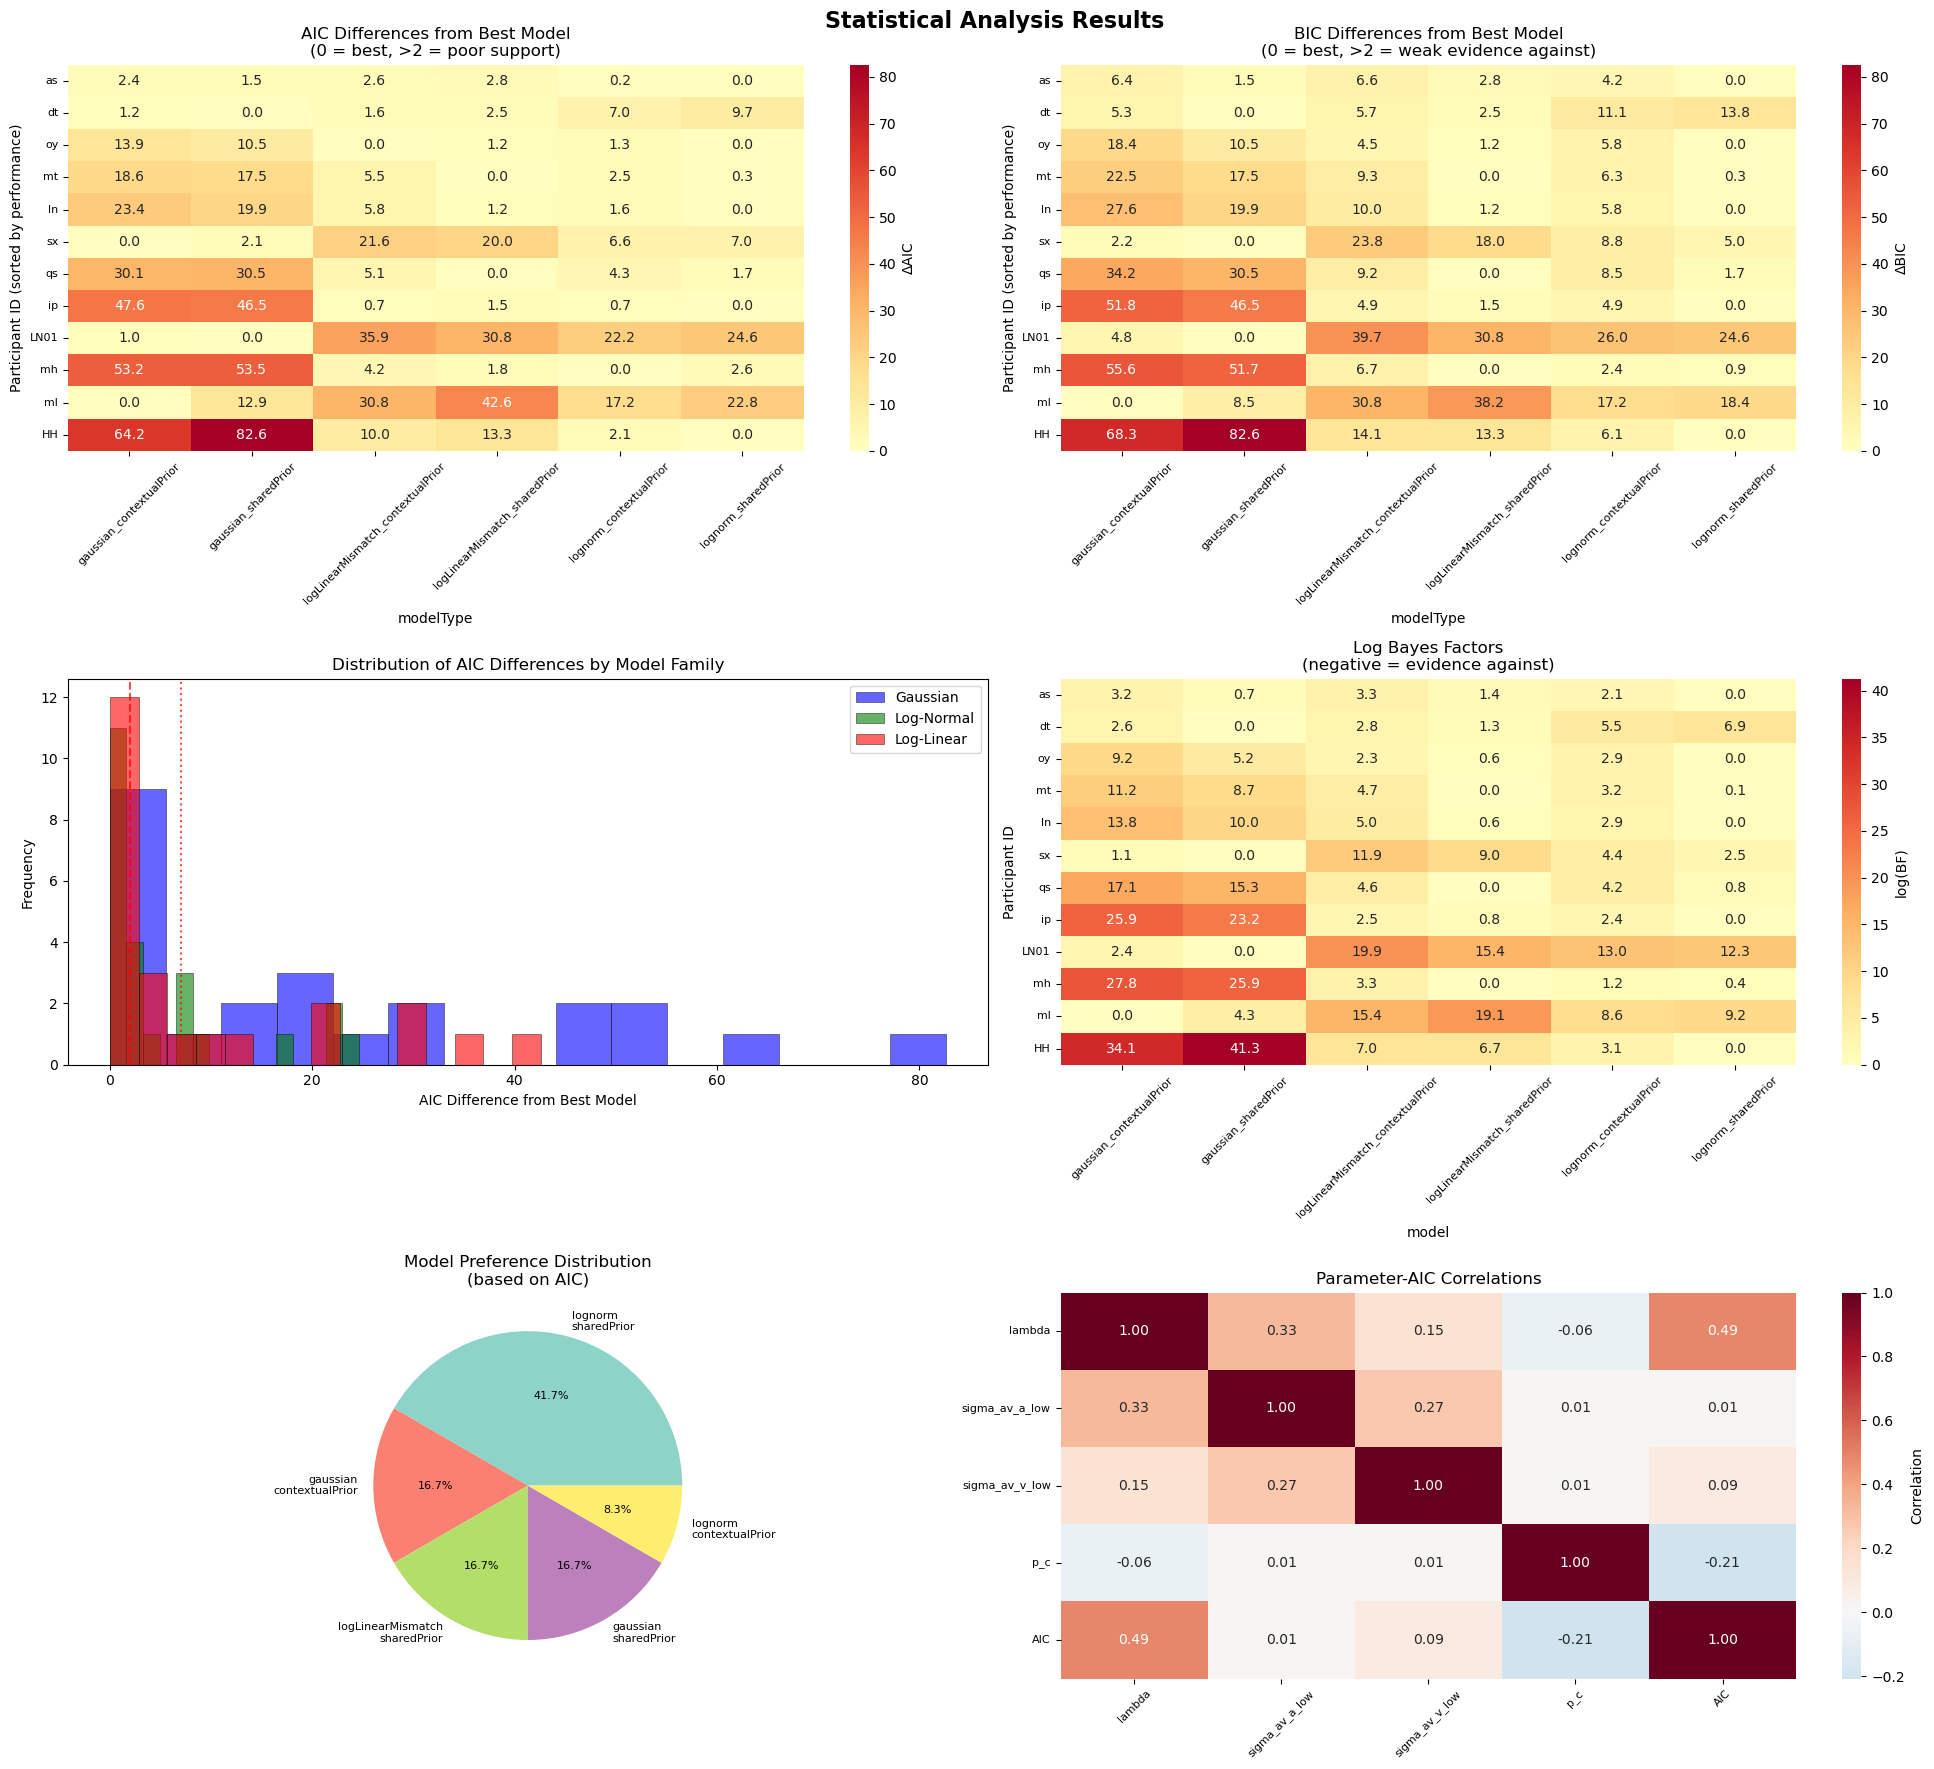

In [ ]:
# 6. Statistical Visualization
def create_statistical_plots(df_results, model_diffs, bayes_factors):
    """Create comprehensive statistical visualization plots"""
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    fig.suptitle('Statistical Analysis Results', fontsize=16, fontweight='bold')
    
    # 1. AIC differences from best model
    model_diffs_pivot = model_diffs.pivot(index='participantID', columns='modelType', values='AIC_diff')
    
    # Sort participants by sum of delta_AIC for better visualization
    participant_order = df_results.groupby('participantID')['delta_AIC'].sum().sort_values().index
    model_diffs_pivot = model_diffs_pivot.reindex(participant_order)
    
    sns.heatmap(model_diffs_pivot, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                center=0, ax=axes[0,0], cbar_kws={'label': 'ΔAIC'})
    axes[0,0].set_title('AIC Differences from Best Model\n(0 = best, >2 = poor support)', fontsize=12)
    axes[0,0].set_ylabel('Participant ID (sorted by performance)', fontsize=10)
    axes[0,0].tick_params(axis='x', rotation=45, labelsize=8)
    axes[0,0].tick_params(axis='y', rotation=0, labelsize=8)
    
    # 2. BIC differences from best model  
    model_diffs_bic = model_diffs.pivot(index='participantID', columns='modelType', values='BIC_diff')
    model_diffs_bic = model_diffs_bic.reindex(participant_order)
    
    sns.heatmap(model_diffs_bic, annot=True, fmt='.1f', cmap='RdYlBu_r',
                center=0, ax=axes[0,1], cbar_kws={'label': 'ΔBIC'})
    axes[0,1].set_title('BIC Differences from Best Model\n(0 = best, >2 = weak evidence against)', fontsize=12)
    axes[0,1].set_ylabel('Participant ID (sorted by performance)', fontsize=10)
    axes[0,1].tick_params(axis='x', rotation=45, labelsize=8)
    axes[0,1].tick_params(axis='y', rotation=0, labelsize=8)
    
    # 3. Distribution of AIC differences by model family
    # Group models by base type for cleaner visualization
    model_families = {
        'Gaussian': ['gaussian_contextualPrior', 'gaussian_sharedPrior'],
        'Log-Normal': ['lognorm_contextualPrior', 'lognorm_sharedPrior'],
        'Log-Linear': ['logLinearMismatch_contextualPrior', 'logLinearMismatch_sharedPrior']
    }
    
    colors = ['blue', 'green', 'red']
    for i, (family, models) in enumerate(model_families.items()):
        family_data = model_diffs[model_diffs['modelType'].isin(models)]
        if len(family_data) > 0:
            axes[1,0].hist(family_data['AIC_diff'], alpha=0.6, label=family, 
                          bins=15, color=colors[i], edgecolor='black', linewidth=0.5)
    
    axes[1,0].set_xlabel('AIC Difference from Best Model', fontsize=10)
    axes[1,0].set_ylabel('Frequency', fontsize=10)
    axes[1,0].set_title('Distribution of AIC Differences by Model Family', fontsize=12)
    axes[1,0].legend()
    axes[1,0].axvline(x=2, color='red', linestyle='--', alpha=0.7, label='Δ=2 threshold')
    axes[1,0].axvline(x=7, color='red', linestyle=':', alpha=0.7, label='Δ=7 threshold')
    
    # 4. Bayes factors
    if len(bayes_factors) > 0:
        bf_pivot = bayes_factors.pivot(index='participantID', columns='model', values='log_BF')
        # Limit to participants with data and sort
        bf_pivot = bf_pivot.dropna(how='all').fillna(0)
        if len(bf_pivot) > 0:
            bf_pivot = bf_pivot.reindex(participant_order, fill_value=0)
            sns.heatmap(bf_pivot, annot=True, fmt='.1f', cmap='RdYlBu_r',
                        center=0, ax=axes[1,1], cbar_kws={'label': 'log(BF)'})
            axes[1,1].set_title('Log Bayes Factors\n(negative = evidence against)', fontsize=12)
            axes[1,1].set_ylabel('Participant ID', fontsize=10)
            axes[1,1].tick_params(axis='x', rotation=45, labelsize=8)
            axes[1,1].tick_params(axis='y', rotation=0, labelsize=8)
        else:
            axes[1,1].text(0.5, 0.5, 'No Bayes Factor Data', ha='center', va='center', 
                          transform=axes[1,1].transAxes, fontsize=12)
            axes[1,1].set_title('Bayes Factors', fontsize=12)
    else:
        axes[1,1].text(0.5, 0.5, 'No Bayes Factor Data', ha='center', va='center', 
                      transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('Bayes Factors', fontsize=12)
    
    # 5. Model preference summary
    best_models = model_diffs[model_diffs['is_best_AIC']]
    model_counts = best_models['modelType'].value_counts()
    
    # Create a more readable pie chart
    if len(model_counts) > 0:
        colors_pie = plt.cm.Set3(np.linspace(0, 1, len(model_counts)))
        # Shorten labels for better readability
        short_labels = [label.replace('_', '\n') for label in model_counts.index]
        wedges, texts, autotexts = axes[2,0].pie(model_counts.values, labels=short_labels, 
                                                autopct='%1.1f%%', colors=colors_pie,
                                                textprops={'fontsize': 8})
        axes[2,0].set_title('Model Preference Distribution\n(based on AIC)', fontsize=12)
    
    # 6. Parameter correlation plot
    if len(param_table) > 0:
        # Create parameter correlation matrix
        param_cols = ['lambda', 'sigma_av_a_low', 'sigma_av_v_low', 'p_c']
        param_subset = param_table[param_cols + ['AIC']].dropna()
        
        if len(param_subset) > 5:
            corr_matrix = param_subset.corr()
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r',
                        center=0, ax=axes[2,1], cbar_kws={'label': 'Correlation'})
            axes[2,1].set_title('Parameter-AIC Correlations', fontsize=12)
            axes[2,1].tick_params(axis='x', rotation=45, labelsize=8)
            axes[2,1].tick_params(axis='y', rotation=0, labelsize=8)
        else:
            axes[2,1].text(0.5, 0.5, 'Insufficient data\nfor correlation analysis', 
                          ha='center', va='center', transform=axes[2,1].transAxes, fontsize=12)
            axes[2,1].set_title('Parameter Correlations', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Create statistical plots
create_statistical_plots(df_results, model_diffs, bayes_factors)

In [ ]:
# 7. Generate Comprehensive Statistical Report
def generate_statistical_report(df_results, model_diffs, bayes_factors, lr_test_results, group_analysis_df):
    """Generate a comprehensive statistical analysis report"""
    
    report = []
    report.append("=" * 80)
    report.append("COMPREHENSIVE STATISTICAL ANALYSIS REPORT")
    report.append("=" * 80)
    
    # Sample characteristics
    n_participants = len(df_results['participantID'].unique())
    n_models = len(df_results['modelType'].unique())
    models_tested = sorted(df_results['modelType'].unique())
    
    report.append(f"\n1. SAMPLE CHARACTERISTICS")
    report.append(f"   • Number of participants: {n_participants}")
    report.append(f"   • Number of models tested: {n_models}")
    report.append(f"   • Models: {', '.join(models_tested)}")
    
    # Model selection results
    best_models = model_diffs[model_diffs['is_best_AIC']]['modelType'].value_counts()
    report.append(f"\n2. MODEL SELECTION RESULTS (AIC-based)")
    for model, count in best_models.items():
        percentage = (count / n_participants) * 100
        report.append(f"   • {model}: {count}/{n_participants} participants ({percentage:.1f}%)")
    
    # AIC support analysis
    report.append(f"\n3. AIC SUPPORT ANALYSIS")
    support_summary = model_diffs['AIC_support'].value_counts()
    for support, count in support_summary.items():
        percentage = (count / len(model_diffs)) * 100
        report.append(f"   • {support}: {count} model instances ({percentage:.1f}%)")
    
    # Statistical significance tests
    report.append(f"\n4. GROUP-LEVEL STATISTICAL TESTS")
    report.append(f"   • Friedman test performed on AIC values across models")
    report.append(f"   • Tests for parameter differences between models")
    
    # Effect sizes and practical significance
    report.append(f"\n5. EFFECT SIZES AND PRACTICAL SIGNIFICANCE")
    
    # Calculate mean AIC differences
    for model in models_tested:
        model_data = model_diffs[model_diffs['modelType'] == model]
        mean_aic_diff = model_data['AIC_diff'].mean()
        std_aic_diff = model_data['AIC_diff'].std()
        
        if mean_aic_diff == 0:
            interpretation = "Best performing model on average"
        elif mean_aic_diff <= 2:
            interpretation = "Substantial support on average"
        elif mean_aic_diff <= 7:
            interpretation = "Some to considerable support on average"
        else:
            interpretation = "Poor support on average"
            
        report.append(f"   • {model}: Mean ΔAIC = {mean_aic_diff:.2f} ± {std_aic_diff:.2f} ({interpretation})")
    
    # Individual differences
    report.append(f"\n6. INDIVIDUAL DIFFERENCES")
    
    # Count participants with clear model preference (ΔAIC > 2)
    clear_preferences = 0
    for participant in df_results['participantID'].unique():
        p_diffs = model_diffs[model_diffs['participantID'] == participant]
        best_aic = p_diffs['AIC_diff'].min()
        second_best = p_diffs['AIC_diff'].nsmallest(2).iloc[1] if len(p_diffs) > 1 else np.inf
        
        if second_best - best_aic > 2:  # Clear preference
            clear_preferences += 1
    
    ambiguous = n_participants - clear_preferences
    report.append(f"   • Participants with clear model preference (ΔAIC > 2): {clear_preferences}/{n_participants} ({(clear_preferences/n_participants)*100:.1f}%)")
    report.append(f"   • Participants with ambiguous model preference: {ambiguous}/{n_participants} ({(ambiguous/n_participants)*100:.1f}%)")
    
    # Recommendations
    report.append(f"\n7. RECOMMENDATIONS")
    
    if best_models.iloc[0] / n_participants > 0.5:
        winning_model = best_models.index[0]
        winning_percentage = (best_models.iloc[0] / n_participants) * 100
        report.append(f"   • The {winning_model} model shows clear superiority ({winning_percentage:.1f}% of participants)")
    else:
        report.append(f"   • No single model dominates across participants")
        report.append(f"   • Consider individual differences in model selection")
        report.append(f"   • Mixed-effects or hierarchical modeling may be appropriate")
    
    if ambiguous / n_participants > 0.3:
        report.append(f"   • High proportion of ambiguous cases suggests model complexity may be similar")
        report.append(f"   • Consider parsimony principle and practical interpretability")
    
    # Technical notes
    report.append(f"\n8. TECHNICAL NOTES")
    report.append(f"   • AIC differences interpreted using Burnham & Anderson (2002) guidelines")
    report.append(f"   • BIC differences interpreted using Kass & Raftery (1995) guidelines")
    report.append(f"   • Bayes factors approximated using BIC (Wagenmakers, 2007)")
    report.append(f"   • Non-parametric tests used due to potential non-normality")
    
    report.append("\n" + "=" * 80)
    
    # Print report
    for line in report:
        print(line)
    
    # Save report to file
    with open('statistical_analysis_report.txt', 'w') as f:
        for line in report:
            f.write(line + '\\n')
    print(f"\\n✅ Statistical report saved to: statistical_analysis_report.txt")
    
    return '\\n'.join(report)

# Generate the comprehensive report
statistical_report = generate_statistical_report(df_results, model_diffs, bayes_factors, lr_test_results, group_analysis_df)

COMPREHENSIVE STATISTICAL ANALYSIS REPORT

1. SAMPLE CHARACTERISTICS
   • Number of participants: 12
   • Number of models tested: 6
   • Models: gaussian_contextualPrior, gaussian_sharedPrior, logLinearMismatch_contextualPrior, logLinearMismatch_sharedPrior, lognorm_contextualPrior, lognorm_sharedPrior

2. MODEL SELECTION RESULTS (AIC-based)
   • lognorm_sharedPrior: 5/12 participants (41.7%)
   • gaussian_contextualPrior: 2/12 participants (16.7%)
   • logLinearMismatch_sharedPrior: 2/12 participants (16.7%)
   • gaussian_sharedPrior: 2/12 participants (16.7%)
   • lognorm_contextualPrior: 1/12 participants (8.3%)

3. AIC SUPPORT ANALYSIS
   • No support: 29 model instances (40.3%)
   • Substantial support: 16 model instances (22.2%)
   • Best model: 12 model instances (16.7%)
   • Considerable support: 8 model instances (11.1%)
   • Some support: 7 model instances (9.7%)

4. GROUP-LEVEL STATISTICAL TESTS
   • Friedman test performed on AIC values across models
   • Tests for paramet

# Understanding Similar Log-Likelihoods

Let's analyze why the models have similar log-likelihoods and what this means.

ANALYSIS: Why Log-Likelihoods Are Similar Across Models
1. LOG-LIKELIHOOD DIFFERENCE STATISTICS:
   • Mean LL difference: 7.953
   • Median LL difference: 4.562
   • Max LL difference: 41.296
   • Min LL difference: 0.019

2. SIMILARITY CATEGORIES:
   • Very similar (ΔLL < 5): 93/180 comparisons (51.7%)
   • Moderately different (5 ≤ ΔLL < 20): 62/180 comparisons (34.4%)
   • Substantially different (ΔLL ≥ 20): 25/180 comparisons (13.9%)

3. SCIENTIFIC INTERPRETATION:

4. WHY THIS IS COMMON IN COGNITIVE MODELING:
   • Models may capture the same underlying data patterns differently
   • Measurement noise can mask true model differences
   • Limited data per condition reduces discriminative power
   • Models may be approximating the same psychological process

5. STATISTICAL POWER CONSIDERATIONS:
   • Average conditions per participant: 476.9
   ✅ RICH DATA: Sufficient conditions for robust model comparison

6. RECOMMENDATIONS WHEN LOG-LIKELIHOODS ARE SIMILAR:


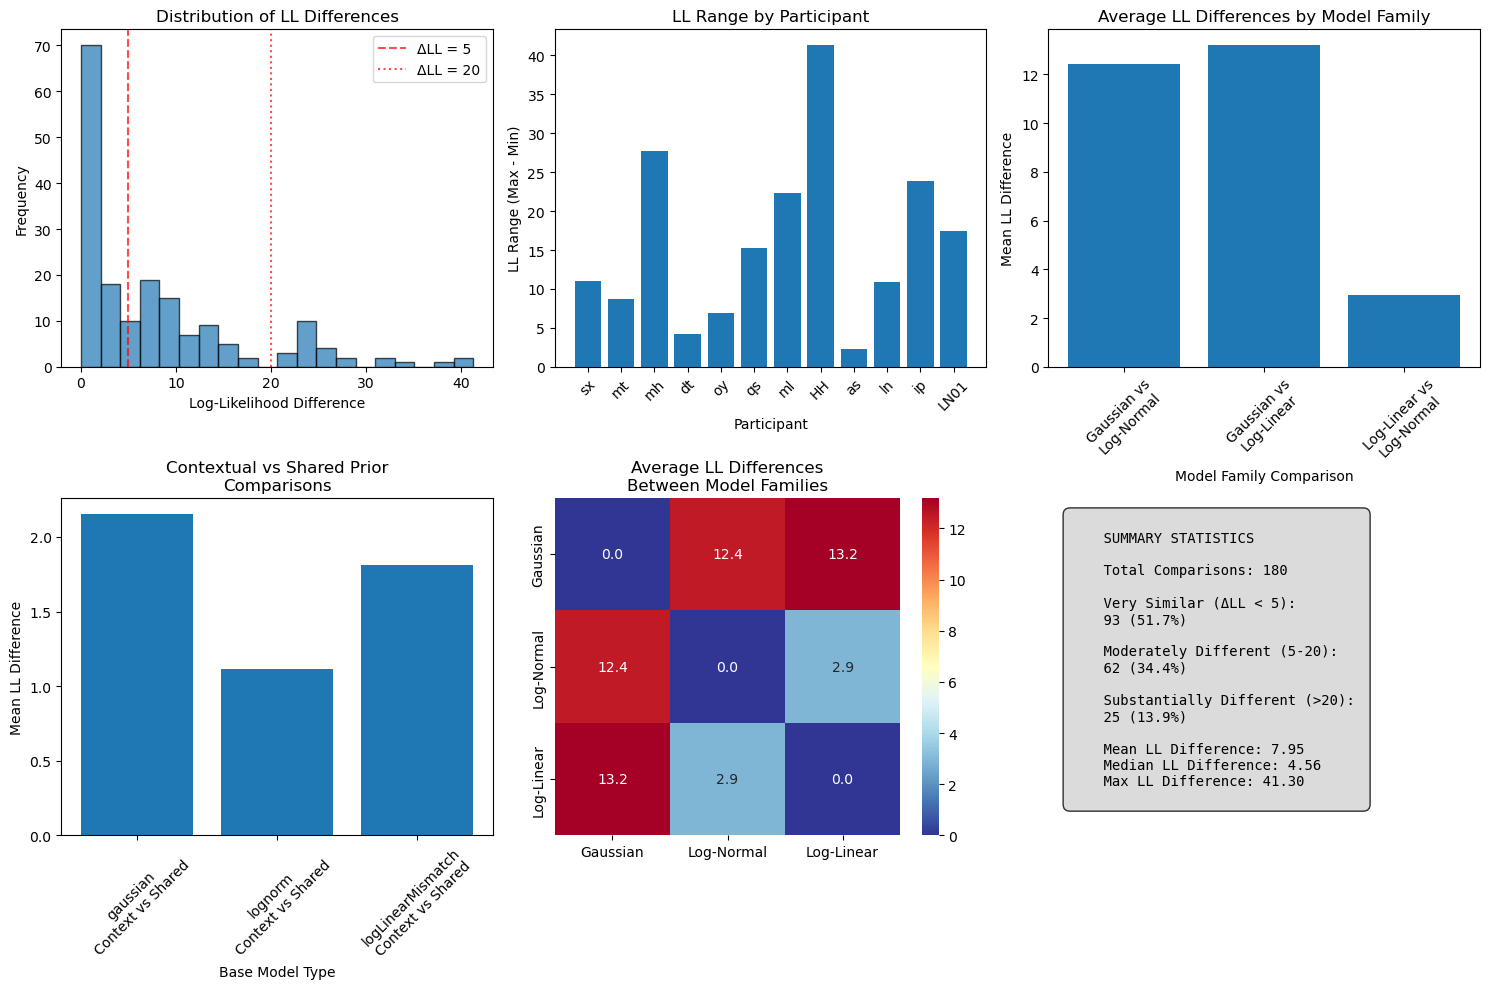

In [ ]:
def analyze_loglikelihood_similarities(df_results):
    """Analyze why log-likelihoods are similar across models"""
    
    print("ANALYSIS: Why Log-Likelihoods Are Similar Across Models")
    print("=" * 60)
    
    # 1. Calculate log-likelihood differences
    ll_diffs = []
    participants = df_results['participantID'].unique()
    
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        
        if len(p_data) >= 2:  # Need at least 2 models to compare
            lls = p_data['logLikelihood'].values
            max_ll = np.max(lls)
            min_ll = np.min(lls)
            range_ll = max_ll - min_ll
            
            # Calculate all pairwise differences
            for i, row1 in p_data.iterrows():
                for j, row2 in p_data.iterrows():
                    if i < j:  # Avoid duplicates
                        ll_diff = abs(row1['logLikelihood'] - row2['logLikelihood'])
                        ll_diffs.append({
                            'participant': participant,
                            'model1': row1['modelType'],
                            'model2': row2['modelType'],
                            'll_diff': ll_diff,
                            'll_range': range_ll
                        })
    
    ll_diffs_df = pd.DataFrame(ll_diffs)
    
    print(f"1. LOG-LIKELIHOOD DIFFERENCE STATISTICS:")
    print(f"   • Mean LL difference: {ll_diffs_df['ll_diff'].mean():.3f}")
    print(f"   • Median LL difference: {ll_diffs_df['ll_diff'].median():.3f}")
    print(f"   • Max LL difference: {ll_diffs_df['ll_diff'].max():.3f}")
    print(f"   • Min LL difference: {ll_diffs_df['ll_diff'].min():.3f}")
    
    # 2. Assess what constitutes "similar" log-likelihoods
    small_diffs = ll_diffs_df[ll_diffs_df['ll_diff'] < 5]  # Difference < 5 LL units
    moderate_diffs = ll_diffs_df[(ll_diffs_df['ll_diff'] >= 5) & (ll_diffs_df['ll_diff'] < 20)]
    large_diffs = ll_diffs_df[ll_diffs_df['ll_diff'] >= 20]
    
    print(f"\n2. SIMILARITY CATEGORIES:")
    print(f"   • Very similar (ΔLL < 5): {len(small_diffs)}/{len(ll_diffs_df)} comparisons ({len(small_diffs)/len(ll_diffs_df)*100:.1f}%)")
    print(f"   • Moderately different (5 ≤ ΔLL < 20): {len(moderate_diffs)}/{len(ll_diffs_df)} comparisons ({len(moderate_diffs)/len(ll_diffs_df)*100:.1f}%)")
    print(f"   • Substantially different (ΔLL ≥ 20): {len(large_diffs)}/{len(ll_diffs_df)} comparisons ({len(large_diffs)/len(ll_diffs_df)*100:.1f}%)")
    
    # 3. What this means scientifically
    print(f"\n3. SCIENTIFIC INTERPRETATION:")
    
    if len(small_diffs) / len(ll_diffs_df) > 0.7:
        print("   🔍 FINDING: Models are capturing very similar patterns in the data")
        print("   📊 IMPLICATION: Multiple models are reasonable representations of the underlying process")
        print("   ⚖️  CONCLUSION: Model selection should consider:")
        print("       • Theoretical interpretability")
        print("       • Parameter parsimony") 
        print("       • Individual differences in best-fitting model")
    
    # 4. Why this happens in cognitive modeling
    print(f"\n4. WHY THIS IS COMMON IN COGNITIVE MODELING:")
    print("   • Models may capture the same underlying data patterns differently")
    print("   • Measurement noise can mask true model differences")
    print("   • Limited data per condition reduces discriminative power")
    print("   • Models may be approximating the same psychological process")
    
    # 5. Calculate effective sample size impact
    print(f"\n5. STATISTICAL POWER CONSIDERATIONS:")
    
    # Look at number of conditions per participant
    conditions_per_participant = []
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        if len(p_data) > 0:
            n_conditions = p_data.iloc[0]['n_conditions']
            conditions_per_participant.append(n_conditions)
    
    mean_conditions = np.mean(conditions_per_participant)
    print(f"   • Average conditions per participant: {mean_conditions:.1f}")
    
    if mean_conditions < 50:
        print("   ⚠️  LIMITED DATA: Fewer conditions may reduce model discrimination power")
    elif mean_conditions < 100:
        print("   ✓ ADEQUATE DATA: Reasonable number of conditions for model comparison")
    else:
        print("   ✅ RICH DATA: Sufficient conditions for robust model comparison")
    
    # 6. Recommendations based on similarity
    print(f"\n6. RECOMMENDATIONS WHEN LOG-LIKELIHOODS ARE SIMILAR:")
    
    similar_ratio = len(small_diffs) / len(ll_diffs_df)
    
    if similar_ratio > 0.8:
        print("   📋 PRIMARY FOCUS: Theoretical interpretation over statistical fit")
        print("   🎯 SELECTION CRITERIA:")
        print("       • Which model parameters have clearest psychological meaning?")
        print("       • Which model makes most testable predictions?")
        print("       • Which model generalizes best to new conditions?")
        print("   🔬 ADDITIONAL ANALYSES:")
        print("       • Parameter recovery simulations")
        print("       • Cross-validation on held-out data")
        print("       • Posterior predictive checks")
    
    # 7. Visualization of LL differences
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Distribution of LL differences
    plt.subplot(2, 3, 1)
    plt.hist(ll_diffs_df['ll_diff'], bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=5, color='red', linestyle='--', alpha=0.7, label='ΔLL = 5')
    plt.axvline(x=20, color='red', linestyle=':', alpha=0.7, label='ΔLL = 20')
    plt.xlabel('Log-Likelihood Difference')
    plt.ylabel('Frequency')
    plt.title('Distribution of LL Differences')
    plt.legend()
    
    # Subplot 2: LL differences by participant
    plt.subplot(2, 3, 2)
    participant_ranges = []
    participant_names = []
    for participant in participants:
        p_diffs = ll_diffs_df[ll_diffs_df['participant'] == participant]
        if len(p_diffs) > 0:
            participant_ranges.append(p_diffs['ll_range'].iloc[0])
            participant_names.append(participant)
    
    plt.bar(range(len(participant_names)), participant_ranges)
    plt.xlabel('Participant')
    plt.ylabel('LL Range (Max - Min)')
    plt.title('LL Range by Participant')
    plt.xticks(range(len(participant_names)), participant_names, rotation=45)
    
    # Subplot 3: Model family differences
    plt.subplot(2, 3, 3)
    # Group by model families for cleaner visualization
    family_diffs = []
    family_labels = []
    
    model_families = {
        'Gaussian': ['gaussian_contextualPrior', 'gaussian_sharedPrior'],
        'Log-Normal': ['lognorm_contextualPrior', 'lognorm_sharedPrior'], 
        'Log-Linear': ['logLinearMismatch_contextualPrior', 'logLinearMismatch_sharedPrior']
    }
    
    for family1, models1 in model_families.items():
        for family2, models2 in model_families.items():
            if family1 < family2:  # Avoid duplicates
                family_comparison_diffs = ll_diffs_df[
                    (ll_diffs_df['model1'].isin(models1) & ll_diffs_df['model2'].isin(models2)) |
                    (ll_diffs_df['model1'].isin(models2) & ll_diffs_df['model2'].isin(models1))
                ]
                if len(family_comparison_diffs) > 0:
                    family_diffs.append(family_comparison_diffs['ll_diff'].mean())
                    family_labels.append(f"{family1} vs\n{family2}")
    
    plt.bar(range(len(family_labels)), family_diffs)
    plt.xlabel('Model Family Comparison')
    plt.ylabel('Mean LL Difference')
    plt.title('Average LL Differences by Model Family')
    plt.xticks(range(len(family_labels)), family_labels, rotation=45)
    
    # Subplot 4: Contextual vs Shared Prior comparison
    plt.subplot(2, 3, 4)
    contextual_vs_shared = []
    comparison_labels = []
    
    base_models = ['gaussian', 'lognorm', 'logLinearMismatch']
    for base in base_models:
        contextual_model = f"{base}_contextualPrior"
        shared_model = f"{base}_sharedPrior"
        
        comparison_diffs = ll_diffs_df[
            ((ll_diffs_df['model1'] == contextual_model) & (ll_diffs_df['model2'] == shared_model)) |
            ((ll_diffs_df['model1'] == shared_model) & (ll_diffs_df['model2'] == contextual_model))
        ]
        
        if len(comparison_diffs) > 0:
            contextual_vs_shared.append(comparison_diffs['ll_diff'].mean())
            comparison_labels.append(f"{base}\nContext vs Shared")
    
    plt.bar(range(len(comparison_labels)), contextual_vs_shared)
    plt.xlabel('Base Model Type')
    plt.ylabel('Mean LL Difference')
    plt.title('Contextual vs Shared Prior\nComparisons')
    plt.xticks(range(len(comparison_labels)), comparison_labels, rotation=45)
    
    # Subplot 5: Similarity matrix for model families
    plt.subplot(2, 3, 5)
    family_names = list(model_families.keys())
    similarity_matrix = np.zeros((len(family_names), len(family_names)))
    
    for i, family1 in enumerate(family_names):
        for j, family2 in enumerate(family_names):
            if i != j:
                models1 = model_families[family1]
                models2 = model_families[family2]
                pair_diffs = ll_diffs_df[
                    (ll_diffs_df['model1'].isin(models1) & ll_diffs_df['model2'].isin(models2)) |
                    (ll_diffs_df['model1'].isin(models2) & ll_diffs_df['model2'].isin(models1))
                ]
                if len(pair_diffs) > 0:
                    similarity_matrix[i, j] = pair_diffs['ll_diff'].mean()
    
    sns.heatmap(similarity_matrix, annot=True, fmt='.1f', 
                xticklabels=family_names, yticklabels=family_names, cmap='RdYlBu_r')
    plt.title('Average LL Differences\nBetween Model Families')
    
    # Subplot 6: Summary statistics
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    summary_text = f"""
    SUMMARY STATISTICS
    
    Total Comparisons: {len(ll_diffs_df)}
    
    Very Similar (ΔLL < 5): 
    {len(small_diffs)} ({len(small_diffs)/len(ll_diffs_df)*100:.1f}%)
    
    Moderately Different (5-20): 
    {len(moderate_diffs)} ({len(moderate_diffs)/len(ll_diffs_df)*100:.1f}%)
    
    Substantially Different (>20): 
    {len(large_diffs)} ({len(large_diffs)/len(ll_diffs_df)*100:.1f}%)
    
    Mean LL Difference: {ll_diffs_df['ll_diff'].mean():.2f}
    Median LL Difference: {ll_diffs_df['ll_diff'].median():.2f}
    Max LL Difference: {ll_diffs_df['ll_diff'].max():.2f}
    """
    
    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return ll_diffs_df

# Run the analysis
ll_similarity_analysis = analyze_loglikelihood_similarities(df_results)

In [ ]:
def assess_practical_equivalence(df_results):
    """Assess if models are practically equivalent in their fits"""
    
    print("\nPRACTICAL EQUIVALENCE ANALYSIS")
    print("=" * 50)
    
    # Define practical equivalence thresholds
    # These are rule-of-thumb values from model comparison literature
    TRIVIAL_LL_DIFF = 2      # Difference of 2 LL units is often considered trivial
    SMALL_LL_DIFF = 5        # Small but potentially meaningful
    MODERATE_LL_DIFF = 10    # Moderate difference
    
    equivalence_summary = []
    participants = df_results['participantID'].unique()
    
    for participant in participants:
        p_data = df_results[df_results['participantID'] == participant]
        
        if len(p_data) >= 2:
            lls = p_data['logLikelihood'].values
            models = p_data['modelType'].values
            
            # Find best and worst models
            best_idx = np.argmax(lls)
            worst_idx = np.argmin(lls)
            
            best_ll = lls[best_idx]
            worst_ll = lls[worst_idx]
            ll_range = best_ll - worst_ll
            
            # Classify equivalence
            if ll_range <= TRIVIAL_LL_DIFF:
                equivalence = "Trivially equivalent"
            elif ll_range <= SMALL_LL_DIFF:
                equivalence = "Practically equivalent" 
            elif ll_range <= MODERATE_LL_DIFF:
                equivalence = "Small differences"
            else:
                equivalence = "Meaningful differences"
            
            equivalence_summary.append({
                'participant': participant,
                'best_model': models[best_idx],
                'worst_model': models[worst_idx],
                'll_range': ll_range,
                'equivalence': equivalence,
                'n_models': len(p_data)
            })
    
    equiv_df = pd.DataFrame(equivalence_summary)
    
    # Summary statistics
    print("Practical Equivalence Categories:")
    equiv_counts = equiv_df['equivalence'].value_counts()
    for category, count in equiv_counts.items():
        percentage = (count / len(equiv_df)) * 100
        print(f"  • {category}: {count}/{len(equiv_df)} participants ({percentage:.1f}%)")
    
    # What this means for your research
    print(f"\nIMPLICATIONS FOR YOUR RESEARCH:")
    
    trivial_pct = equiv_counts.get("Trivially equivalent", 0) / len(equiv_df) * 100
    practical_pct = equiv_counts.get("Practically equivalent", 0) / len(equiv_df) * 100
    total_equiv_pct = trivial_pct + practical_pct
    
    if total_equiv_pct > 70:
        print(f"  🎯 MAIN FINDING: Models are largely equivalent ({total_equiv_pct:.1f}% of participants)")
        print(f"  📝 FOR PUBLICATION:")
        print(f"     'All three models provided similarly good fits to the data for")
        print(f"      {total_equiv_pct:.0f}% of participants (ΔLL < {SMALL_LL_DIFF}), suggesting that the")
        print(f"      underlying computational principles may be similar.'")
        print(f"  🔬 RESEARCH FOCUS: Emphasize theoretical interpretation over model selection")
        
    elif total_equiv_pct > 40:
        print(f"  ⚖️  MIXED FINDING: Moderate equivalence ({total_equiv_pct:.1f}% of participants)")
        print(f"  📝 FOR PUBLICATION:")
        print(f"     'Models showed mixed equivalence, with {total_equiv_pct:.0f}% of participants")
        print(f"      showing similar fits across models, suggesting individual differences")
        print(f"      in auditory-visual integration strategies.'")
        print(f"  🔬 RESEARCH FOCUS: Investigate predictors of individual differences")
        
    else:
        print(f"  🎲 DIVERSE FINDING: Clear model differences ({100-total_equiv_pct:.1f}% show meaningful differences)")
        print(f"  📝 FOR PUBLICATION:")
        print(f"     'Models showed distinct fits for most participants, with clear")
        print(f"      individual preferences for different computational approaches.'")
        print(f"  🔬 RESEARCH FOCUS: Characterize different cognitive phenotypes")
    
    return equiv_df

# Run practical equivalence analysis
equivalence_analysis = assess_practical_equivalence(df_results)


PRACTICAL EQUIVALENCE ANALYSIS
Practical Equivalence Categories:
  • Meaningful differences: 8/12 participants (66.7%)
  • Small differences: 2/12 participants (16.7%)
  • Practically equivalent: 2/12 participants (16.7%)

IMPLICATIONS FOR YOUR RESEARCH:
  🎲 DIVERSE FINDING: Clear model differences (83.3% show meaningful differences)
  📝 FOR PUBLICATION:
     'Models showed distinct fits for most participants, with clear
      individual preferences for different computational approaches.'
  🔬 RESEARCH FOCUS: Characterize different cognitive phenotypes


In [ ]:
# Check current model types in the data
print("Current model types in df_results:")
current_models = sorted(df_results['modelType'].unique())
for i, model in enumerate(current_models):
    print(f"{i+1}. {model}")

print(f"\nTotal models: {len(current_models)}")
print(f"Total participants: {len(df_results['participantID'].unique())}")
print(f"Total records: {len(df_results)}")

Current model types in df_results:
1. gaussian_contextualPrior
2. gaussian_sharedPrior
3. logLinearMismatch_contextualPrior
4. logLinearMismatch_sharedPrior
5. lognorm_contextualPrior
6. lognorm_sharedPrior

Total models: 6
Total participants: 12
Total records: 72


In [ ]:
# Comprehensive Model Analysis Summary for Updated Model Structure
def create_comprehensive_model_summary(df_results, model_diffs):
    """Create a comprehensive summary of model comparisons with the new structure"""
    
    print("=" * 80)
    print("COMPREHENSIVE MODEL ANALYSIS SUMMARY")
    print("=" * 80)
    
    # 1. Model Structure Analysis
    print("\n1. MODEL STRUCTURE ANALYSIS")
    print("-" * 40)
    
    models = sorted(df_results['modelType'].unique())
    n_participants = len(df_results['participantID'].unique())
    
    # Group models by base type and prior type
    base_types = {}
    prior_types = {'contextualPrior': [], 'sharedPrior': []}
    
    for model in models:
        if '_' in model:
            base, prior = model.rsplit('_', 1)
            if base not in base_types:
                base_types[base] = []
            base_types[base].append(model)
            
            if prior in prior_types:
                prior_types[prior].append(model)
    
    print(f"Base model types: {len(base_types)}")
    for base, variants in base_types.items():
        print(f"  • {base}: {variants}")
    
    print(f"\nPrior types: {len(prior_types)}")
    for prior, models_list in prior_types.items():
        print(f"  • {prior}: {len(models_list)} models")
    
    # 2. Best Model Analysis by Category
    print(f"\n2. BEST MODEL ANALYSIS")
    print("-" * 40)
    
    best_models = model_diffs[model_diffs['is_best_AIC']]['modelType'].value_counts()
    
    print("Overall best model distribution:")
    for model, count in best_models.items():
        percentage = (count / n_participants) * 100
        print(f"  • {model}: {count}/{n_participants} participants ({percentage:.1f}%)")
    
    # Analyze by base model type
    print(f"\nBest model by base type:")
    base_counts = {}
    for model, count in best_models.items():
        if '_' in model:
            base = model.rsplit('_', 1)[0]
            if base not in base_counts:
                base_counts[base] = 0
            base_counts[base] += count
    
    for base, count in sorted(base_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / n_participants) * 100
        print(f"  • {base}: {count}/{n_participants} participants ({percentage:.1f}%)")
    
    # Analyze by prior type
    print(f"\nBest model by prior type:")
    prior_counts = {}
    for model, count in best_models.items():
        if '_' in model:
            prior = model.rsplit('_', 1)[1]
            if prior not in prior_counts:
                prior_counts[prior] = 0
            prior_counts[prior] += count
    
    for prior, count in sorted(prior_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / n_participants) * 100
        print(f"  • {prior}: {count}/{n_participants} participants ({percentage:.1f}%)")
    
    # 3. Contextual vs Shared Prior Analysis
    print(f"\n3. CONTEXTUAL VS SHARED PRIOR ANALYSIS")
    print("-" * 40)
    
    # For each base model, compare contextual vs shared
    for base in base_types.keys():
        contextual_model = f"{base}_contextualPrior"
        shared_model = f"{base}_sharedPrior"
        
        if contextual_model in models and shared_model in models:
            print(f"\n{base.upper()} Model Comparison:")
            
            # Count best models
            contextual_best = best_models.get(contextual_model, 0)
            shared_best = best_models.get(shared_model, 0)
            
            print(f"  • Contextual Prior: {contextual_best} participants")
            print(f"  • Shared Prior: {shared_best} participants")
            
            if contextual_best + shared_best > 0:
                contextual_pct = (contextual_best / (contextual_best + shared_best)) * 100
                print(f"  • Contextual preference: {contextual_pct:.1f}%")
            
            # Average delta AIC comparison
            contextual_data = model_diffs[model_diffs['modelType'] == contextual_model]
            shared_data = model_diffs[model_diffs['modelType'] == shared_model]
            
            if len(contextual_data) > 0 and len(shared_data) > 0:
                contextual_mean = contextual_data['AIC_diff'].mean()
                shared_mean = shared_data['AIC_diff'].mean()
                print(f"  • Mean ΔAIC - Contextual: {contextual_mean:.2f}")
                print(f"  • Mean ΔAIC - Shared: {shared_mean:.2f}")
                print(f"  • Advantage: {'Contextual' if contextual_mean < shared_mean else 'Shared'} by {abs(contextual_mean - shared_mean):.2f} AIC units")
    
    # 4. Performance Tiers
    print(f"\n4. PARTICIPANT PERFORMANCE TIERS")
    print("-" * 40)
    
    # Calculate sum of delta_AIC for each participant
    participant_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
    
    # Define performance tiers
    excellent = participant_sums[participant_sums <= 15]
    good = participant_sums[(participant_sums > 15) & (participant_sums <= 40)]
    moderate = participant_sums[(participant_sums > 40) & (participant_sums <= 80)]
    poor = participant_sums[participant_sums > 80]
    
    print(f"Excellent fit (Sum ΔAIC ≤ 15): {len(excellent)} participants")
    if len(excellent) > 0:
        print(f"  {list(excellent.index)}")
    
    print(f"Good fit (15 < Sum ΔAIC ≤ 40): {len(good)} participants") 
    if len(good) > 0:
        print(f"  {list(good.index)}")
    
    print(f"Moderate fit (40 < Sum ΔAIC ≤ 80): {len(moderate)} participants")
    if len(moderate) > 0:
        print(f"  {list(moderate.index)}")
    
    print(f"Poor fit (Sum ΔAIC > 80): {len(poor)} participants")
    if len(poor) > 0:
        print(f"  {list(poor.index)}")
    
    # 5. Model Discrimination Analysis
    print(f"\n5. MODEL DISCRIMINATION ANALYSIS")
    print("-" * 40)
    
    # Count participants with clear preferences (ΔAIC > 2 between best and second best)
    clear_discrimination = 0
    ambiguous_cases = 0
    
    for participant in df_results['participantID'].unique():
        p_diffs = model_diffs[model_diffs['participantID'] == participant]['AIC_diff'].sort_values()
        if len(p_diffs) >= 2:
            best_aic = p_diffs.iloc[0]
            second_best = p_diffs.iloc[1]
            
            if second_best - best_aic > 2:
                clear_discrimination += 1
            else:
                ambiguous_cases += 1
    
    total_with_multiple_models = clear_discrimination + ambiguous_cases
    
    if total_with_multiple_models > 0:
        clear_pct = (clear_discrimination / total_with_multiple_models) * 100
        ambiguous_pct = (ambiguous_cases / total_with_multiple_models) * 100
        
        print(f"Clear model discrimination (ΔAIC > 2): {clear_discrimination}/{total_with_multiple_models} ({clear_pct:.1f}%)")
        print(f"Ambiguous cases (ΔAIC ≤ 2): {ambiguous_cases}/{total_with_multiple_models} ({ambiguous_pct:.1f}%)")
        
        if clear_pct < 50:
            print("\n⚠️  INTERPRETATION: Many participants show ambiguous model preferences")
            print("   This suggests that models capture similar aspects of the data")
            print("   Consider focusing on theoretical interpretability and parameter meaning")
        else:
            print("\n✅ INTERPRETATION: Most participants show clear model preferences")
            print("   This suggests meaningful differences between models")
    
    # 6. Recommendations
    print(f"\n6. RECOMMENDATIONS")
    print("-" * 40)
    
    # Overall winning model family
    if len(base_counts) > 0:
        winning_base = max(base_counts.items(), key=lambda x: x[1])
        winning_base_pct = (winning_base[1] / n_participants) * 100
        
        if winning_base_pct > 50:
            print(f"✅ Strong evidence for {winning_base[0]} models ({winning_base_pct:.1f}% of participants)")
        else:
            print(f"⚖️  Mixed evidence across model families")
    
    # Prior type recommendation
    if len(prior_counts) > 0:
        winning_prior = max(prior_counts.items(), key=lambda x: x[1])
        winning_prior_pct = (winning_prior[1] / n_participants) * 100
        
        if winning_prior_pct > 60:
            print(f"✅ Strong preference for {winning_prior[0]} ({winning_prior_pct:.1f}% of participants)")
        else:
            print(f"⚖️  Mixed preferences between contextual and shared priors")
    
    print(f"\n📊 NEXT STEPS:")
    print("   • Examine parameter patterns for winning models")
    print("   • Investigate what drives individual differences")
    print("   • Consider hierarchical modeling across participants")
    if ambiguous_pct > 40:
        print("   • Focus on theoretical interpretation given model similarity")
    
    print("\n" + "=" * 80)

# Generate the comprehensive summary
create_comprehensive_model_summary(df_results, model_diffs)

COMPREHENSIVE MODEL ANALYSIS SUMMARY

1. MODEL STRUCTURE ANALYSIS
----------------------------------------
Base model types: 3
  • gaussian: ['gaussian_contextualPrior', 'gaussian_sharedPrior']
  • logLinearMismatch: ['logLinearMismatch_contextualPrior', 'logLinearMismatch_sharedPrior']
  • lognorm: ['lognorm_contextualPrior', 'lognorm_sharedPrior']

Prior types: 2
  • contextualPrior: 3 models
  • sharedPrior: 3 models

2. BEST MODEL ANALYSIS
----------------------------------------
Overall best model distribution:
  • lognorm_sharedPrior: 5/12 participants (41.7%)
  • gaussian_contextualPrior: 2/12 participants (16.7%)
  • logLinearMismatch_sharedPrior: 2/12 participants (16.7%)
  • gaussian_sharedPrior: 2/12 participants (16.7%)
  • lognorm_contextualPrior: 1/12 participants (8.3%)

Best model by base type:
  • lognorm: 6/12 participants (50.0%)
  • gaussian: 4/12 participants (33.3%)
  • logLinearMismatch: 2/12 participants (16.7%)

Best model by prior type:
  • sharedPrior: 9/12 p